#### Imports

In [1]:
import sys, subprocess
# System operations
import os
os.environ["OPTUNA_WORKER_ID"] = os.getenv("OPTUNA_WORKER_ID", "0")
# pin GPU per kernel or set "" to force CPU
os.environ["CUDA_VISIBLE_DEVICES"] = os.getenv("CUDA_VISIBLE_DEVICES", "0")
# reduce thread contention
os.environ.setdefault("OMP_NUM_THREADS", "1")
os.environ.setdefault("MKL_NUM_THREADS", "1")

WORKER_ID = int(os.getenv("OPTUNA_WORKER_ID", "0"))
print("WORKER_ID:", WORKER_ID, "CUDA_VISIBLE_DEVICES:", os.environ.get("CUDA_VISIBLE_DEVICES"))

# Type hinting
from typing import Any, List, Mapping, Tuple, Union

# Data visualization
import matplotlib.pyplot as plt

# Data manipulation
import numpy as np
import pandas as pd
import gymnasium as gym
import torch as th
import copy, time, json, pickle

# CityLearn
import citylearn
from citylearn.data import DataSet
from citylearn.wrappers import NormalizedObservationWrapper, StableBaselines3Wrapper
from citylearn.citylearn import CityLearnEnv

# RL algorithms
from stable_baselines3 import DQN
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.monitor import Monitor

# Utils
from utils.env_utils import DiscretizeActionWrapper, keep_only_electrical_storage, keep_only_core_observations

# Debugging
print('Python:', sys.version.split()[0])
print('Torch :', th.__version__)
print('CityLearn:', citylearn.__version__)
subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", "optuna", "optuna-dashboard"])
print("Optuna installed.")

WORKER_ID: 0 CUDA_VISIBLE_DEVICES: MIG-1b6dd7d2-9d70-5ae3-a639-4984d951a4ce
Couldn't import dot_parser, loading of dot files will not be possible.


2025-10-21 10:52:15.086300: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-21 10:52:15.220743: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1761036735.266337 2321127 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1761036735.286003 2321127 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1761036735.406175 2321127 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

Python: 3.11.7
Torch : 2.7.0+cu126
CityLearn: 2.4.1
Optuna installed.



[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: /hkfs/home/haicore/iai/cj9272/citylearn_env/bin/python -m pip install --upgrade pip


#### Variables

In [4]:
DATASET_NAME = 'citylearn_challenge_2023_phase_3_1' 
ROOT_DIR = r'/hkfs/home/haicore/iai/cj9272/Bachelorthesis_DQN_Agent/data/datasets/citylearn_challenge_2023_phase_3_1'
LOG_DIR = r'/hkfs/home/haicore/iai/cj9272/logs/dqn'
REWARD_FN = {  # CostReward 
    'type': 'citylearn.reward_function.CostReward',
    'attributes': {}
}
PRICING_FILE = 'pricing_germany_2023_june_to_august.csv'
ACTION_LABELS = ['discharge_full','discharge_half','idle','charge_half','charge_full']
NAME_TO_FRAC = {
    'discharge_full': -1.0, 
    # energy = -1*capacity,
    # diff = soc_init-0.2 e.g. diff = 0.8
    # -(diff*capacity*sqrt(0.95)) e.g. -0.77
    # max_output_power = 3.32 * capacity_power_curve values 
    # (Given the current SoC, look up the max allowed output power fraction
    # from the curve (by linear interpolation) and multiply 
    # by the system’s nominal power to get max_output_power)
    # energy = max(-max_output_power, -(diff*capacity*sqrt(0.95)), -1*capacity)
    'discharge_half': -0.5,
    'idle': 0.0,
    'charge_half': 0.5,
    'charge_full': 1.0,
}
INT_TO_FRAC = np.array([NAME_TO_FRAC[n] for n in ACTION_LABELS], dtype=np.float32)

EVAL_EPISODES = 10
TRAIN_EPISODES = 50
TIMESTEPS_PER_TRAIN_EPISODE = 1463


# feature removal: price
EVAL_FILE_WITHOUT_PRICE = os.path.join(LOG_DIR, "dqn_split_10eval_final_without_price.pkl") 
# feature removal: solar generation
EVAL_FILE_WITHOUT_SOLAR = os.path.join(LOG_DIR, "dqn_split_10eval_final_without_solar.pkl") 
# feature removal: net_load
EVAL_FILE_WITHOUT_NET_LOAD = os.path.join(LOG_DIR, "dqn_split_10eval_final_without_net_load.pkl") 
# feature removal: price and net_load
EVAL_FILE_WITHOUT_PRICE_AND_NET_LOAD = os.path.join(LOG_DIR, "dqn_split_10eval_final_without_price_and_net_load.pkl") 


EVAL_FILE_DETERMINISTIC = os.path.join(LOG_DIR, "dqn_split_10eval_final.pkl") 
EVAL_FILE_STOCHASTIC = os.path.join(LOG_DIR, "dqn_split_10eval_final_not_deterministic.pkl") 


# Training and Evaluation files
TRAINING_FILE = os.path.join(LOG_DIR, "dqn_split_50train_final") # xxx
TRAIN_STEPS_FILE = os.path.join(LOG_DIR, "dqn_split_50train_steps_final.csv") # xxx
TRAIN_EPISODES_FILE = os.path.join(LOG_DIR, "dqn_split_50train_episodes_final.csv") # xxx
#EVAL_FILE = os.path.join(LOG_DIR, "dqn_split_10eval_final_not_deterministic.pkl") # xxx change back
EVAL_FILE = EVAL_FILE_WITHOUT_PRICE_AND_NET_LOAD 


MONTH_SLICES = {
    "train": (0, 1463),      # train: june - july
    "test": (1464, 2207),    # test: august
}
MAX_TIMESTEPS = 744

##### Data

In [5]:
observations = [
    # building_df
    'month', 'hour', 'day_type', 'daylight_savings_status',
    'indoor_dry_bulb_temperature',
    'average_unmet_cooling_setpoint_difference',
    'indoor_relative_humidity',
    'non_shiftable_load', 'dhw_demand',
    'cooling_demand', 'heating_demand',
    'solar_generation', 'occupant_count',
    'indoor_dry_bulb_temperature_cooling_set_point',
    'indoor_dry_bulb_temperature_heating_set_point', 'hvac_mode',
    # weather_df
    'outdoor_dry_bulb_temperature',
    'outdoor_relative_humidity',
    'diffuse_solar_irradiance',
    'direct_solar_irradiance',
    'outdoor_dry_bulb_temperature_predicted_1',
    'outdoor_dry_bulb_temperature_predicted_2',
    'outdoor_dry_bulb_temperature_predicted_3',
    'outdoor_relative_humidity_predicted_1',
    'outdoor_relative_humidity_predicted_2',
    'outdoor_relative_humidity_predicted_3',
    'diffuse_solar_irradiance_predicted_1',
    'diffuse_solar_irradiance_predicted_2',
    'diffuse_solar_irradiance_predicted_3',
    'direct_solar_irradiance_predicted_1',
    'direct_solar_irradiance_predicted_2',
    'direct_solar_irradiance_predicted_3',
    # carbon_df 
    'carbon_intensity',
    # pricing_df
    'electricity_pricing',
    'electricity_pricing_predicted_1',
    'electricity_pricing_predicted_2',
    'electricity_pricing_predicted_3'
]
bld_cols = [
            'month', 'hour', 'day_type', 'daylight_savings_status',
            'indoor_dry_bulb_temperature',
            'average_unmet_cooling_setpoint_difference',
            'indoor_relative_humidity', 'non_shiftable_load',
            'dhw_demand', 'cooling_demand', 'heating_demand',
            'solar_generation', 'occupant_count',
            'indoor_dry_bulb_temperature_cooling_set_point',
            'indoor_dry_bulb_temperature_heating_set_point',
            'hvac_mode'
]
wth_cols = [
    'outdoor_dry_bulb_temperature',
    'outdoor_relative_humidity',
    'diffuse_solar_irradiance',
    'direct_solar_irradiance'
]

##### Schema

In [6]:
# --- Load schema ---
dataset = DataSet()
schema = dataset.get_schema(DATASET_NAME)
schema['root_directory'] = ROOT_DIR
schema['reward_function'] = REWARD_FN

price_file = PRICING_FILE # Set pricing file
if 'buildings' not in schema:
    raise RuntimeError("schema does not contain 'buildings' (make sure schema is loaded first)")
for bname, bconf in schema['buildings'].items():
    bconf['pricing'] = price_file

core_observations = [
        'electrical_storage_soc',
        'electricity_pricing',
        'net_electricity_consumption',
        'solar_generation',
    ]
schema = keep_only_electrical_storage(schema) # Activate only the electrical storage control (fix "Expected 18 actions but got 1")
schema = keep_only_core_observations(schema, core=core_observations, extra_keep=['carbon_intensity', 'non_shiftable_load'], drop_predictions=False)

INFO:root:Go here /home/iai/cj9272/.cache/citylearn/v2.4.1/datasets/citylearn_challenge_2023_phase_3_1/schema.json 


##### View active observations

In [5]:
top_obs = schema.get('observations', {})
active_top = [k for k,v in top_obs.items() if isinstance(v, dict) and v.get('active', False)]
print("Active observations:", active_top)

Active observations: ['carbon_intensity', 'non_shiftable_load', 'solar_generation', 'electrical_storage_soc', 'net_electricity_consumption', 'electricity_pricing']


#### Logger

In [7]:
class TrainLoggerCallback(BaseCallback):
    def __init__(self, verbose=0):
        super().__init__(verbose)
        self.rows = []
        self.losses = []
        self.loss_timesteps = []
        self.episode_rewards = []
        self._current_ep_rewards = []
        self._current_ep_counts = []
        self._current_step_in_episode = []
        self.df = pd.DataFrame()
        self.ep_df = pd.DataFrame()
        self._obs_names = None

    def _get_citylearn_env_for_idx(self, idx: int):
        from citylearn.citylearn import CityLearnEnv
        env = self.training_env
        try:
            sub = env.envs[idx]
        except Exception:
            sub = getattr(env, "env", getattr(env, "unwrapped", env))
        seen = set()
        cur = sub
        while cur is not None and id(cur) not in seen:
            if isinstance(cur, CityLearnEnv):
                return cur
            seen.add(id(cur))
            cur = getattr(cur, "env", getattr(cur, "unwrapped", None))
        return None

    def _on_training_start(self) -> None:
        try:
            n_envs = self.training_env.num_envs
        except AttributeError:
            n_envs = 1
        self._current_ep_rewards = [0.0] * n_envs
        self._current_ep_counts = [1] * n_envs
        self._current_step_in_episode = [0] * n_envs
        # capture observation names (single-building case)
        try:
            base = self._get_citylearn_env_for_idx(0)
            if base is not None:
                self._obs_names = list(base.observation_names[0])
        except Exception:
            self._obs_names = None
        super()._on_training_start()

    def _on_step(self) -> bool:
        obs_vec = self.locals.get("new_obs")
        acts    = self.locals.get("actions")
        rews    = self.locals.get("rewards")
        dones   = self.locals.get("dones")
        step    = int(self.num_timesteps)

        loss_val = self.logger.name_to_value.get("train/loss")
        if loss_val is not None:
            self.losses.append(float(loss_val))
            self.loss_timesteps.append(step)

        for idx, (obs, act, rew, done) in enumerate(zip(obs_vec, acts, rews, dones)):
            row = {}
            # Basic step metadata
            row.update({
                "global_step": step,
                "env_id": idx,
                "episode": self._current_ep_counts[idx],
                "action_id": int(act),
                "reward": float(rew),
            })

            # Optional: action label & mapped fraction
            try:
                a_id = int(act)
                row['action_label'] = ACTION_LABELS[a_id]
                row['action_frac'] = float(INT_TO_FRAC[a_id])
            except Exception:
                row['action_label'] = None
                row['action_frac'] = None

            # Pull CityLearn internals for consistent indexing
            try:
                base = self._get_citylearn_env_for_idx(idx)
                if base is not None:
                    b = base.buildings[0]
                    t  = b.time_step
                    tp = max(0, t-1)  # previous step = the one your obs net_load refers to

                    # Robust chargers
                    chargers_arr = getattr(b, "_Building__chargers_electricity_consumption", None)
                    chargers_tp = float(chargers_arr[tp]) if chargers_arr is not None else float('nan')
                    chargers_t  = float(chargers_arr[t])  if chargers_arr is not None else float('nan')

                    # Component loads on tp (this is the consistent balance slice)
                    row.update({
                        "price": float(b.pricing.electricity_pricing[tp]),
                        "net_load": float(b.net_electricity_consumption[tp]),
                        "non_shiftable_load": float(b.non_shiftable_load_device.electricity_consumption[tp]),
                        "cooling_load": float(b.cooling_device.electricity_consumption[tp]),
                        "heating_load": float(b.heating_device.electricity_consumption[tp]),
                        "dhw_load": float(b.dhw_device.electricity_consumption[tp]),
                        "chargers_load": chargers_tp,
                        "storage_load": float(b.electrical_storage.electricity_consumption[tp]),
                        "solar": float(b.solar_generation[tp]),  # negative for generation
                        "battery_soc": float(b.electrical_storage.soc[tp]),
                        "battery_energy_balance": float(b.electrical_storage.energy_balance[tp]),
                        "simulate_power_outage": bool(getattr(b, 'simulate_power_outage', False)),
                        "power_outage": bool(getattr(b, 'power_outage', False)),
                    })

                # If base is None, we still keep the obs-based fields we already wrote
            except Exception:
                pass

            self.rows.append(row)

            # bookkeeping
            self._current_ep_rewards[idx] += float(rew)
            self._current_step_in_episode[idx] += 1
            if done:
                self.episode_rewards.append(self._current_ep_rewards[idx])
                self._current_ep_rewards[idx] = 0.0
                self._current_step_in_episode[idx] = 0
                self._current_ep_counts[idx] += 1

        return True

    def _on_training_end(self) -> None:
        self.df = pd.DataFrame(self.rows)
        self.ep_df = pd.DataFrame({
            "episode_global": range(1, len(self.episode_rewards) + 1),
            "return": self.episode_rewards
        })
        super()._on_training_end()

#### Training

In [8]:
# Keep only one building: 1-D action
one_building = "Building_1"
schema_1b = dict(schema)  # shallow copy
schema_1b['buildings'] = {k: v for k, v in schema['buildings'].items() if k == one_building}
if not schema_1b['buildings']:
    raise RuntimeError(f"{one_building} not found in schema['buildings']")


# ---- Define train test split ----
train_start, train_end = MONTH_SLICES["train"]
test_start, test_end = MONTH_SLICES["test"]


# --- Build train env ---
schema_train = dict(schema_1b)
train_env = CityLearnEnv(schema=schema_train, 
                        central_agent=True,
                        simulation_start_time_step=train_start,
                        simulation_end_time_step=train_end)


train_env = NormalizedObservationWrapper(train_env)
train_env = StableBaselines3Wrapper(train_env)
train_env = DiscretizeActionWrapper(train_env, n_bins=5) # Discretize action space for DQN
train_env = Monitor(train_env)

train_callback = TrainLoggerCallback()

TOTAL_TIMESTEPS = TRAIN_EPISODES * TIMESTEPS_PER_TRAIN_EPISODE

# Best parameters found by optuna
model = DQN(
    policy='MlpPolicy',
    env=train_env,
    seed=0,
    learning_rate=0.0002752350841138598,
    gamma=0.9851293040985031,
    buffer_size=125000,
    batch_size=256,
    tau=0.05065165487856718,
    target_update_interval=3500,
    train_freq=5,
    gradient_steps=4,
    exploration_fraction=0.18063198209981218,
    exploration_final_eps=0.05601773593918628,
    learning_starts=1000,
    verbose=1, # logging: info
    policy_kwargs=dict(net_arch=[512, 512], activation_fn=th.nn.ReLU),
)

/hkfs/home/haicore/iai/cj9272/Bachelorthesis_DQN_Agent/data/datasets/citylearn_challenge_2023_phase_3_1
Dataset '/hkfs/home/haicore/iai/cj9272/Bachelorthesis_DQN_Agent/data/datasets/citylearn_challenge_2023_phase_3_1' copied to '/hkfs/home/haicore/iai/cj9272/Bachelorthesis_DQN_Agent/data/datasets/citylearn_challenge_2023_phase_3_1/../../../../results/2025-10-21_10-53-33'
Using cuda device
Wrapping the env in a DummyVecEnv.


##### View building data

In [8]:
# Convenience: inspect building
print("Action space:", train_env.action_space)

b = train_env.unwrapped.buildings[0]
print("Train env building:", b.name)
print("Train env time steps:", train_env.unwrapped.time_steps)
print("Train env sim range:", train_env.unwrapped.episode_tracker.simulation_start_time_step, "->", train_env.unwrapped.episode_tracker.simulation_end_time_step)

print(b.active_actions)
print("Battery capacity:", b.electrical_storage.capacity)
print("Battery nominal power:", getattr(b.electrical_storage, "nominal_power", "N/A"))
print("Action names:", train_env.unwrapped.action_names)
print("Action space:", train_env.action_space)

print("Battery attributes:", dir(b.electrical_storage))
print("Initial SOC:", b.electrical_storage.initial_soc)
print("SOC (full array):", b.electrical_storage.soc)
print("First 20 SOC values:", b.electrical_storage.soc[:20])
print("Current timestep:", b.time_step)
print("Current SOC:", b.electrical_storage.soc[b.time_step])
print("Total timesteps:", train_env.unwrapped.time_steps)

Action space: Discrete(5)
Train env building: Building_1
Train env time steps: 1464
Train env sim range: 0 -> 1463
['electrical_storage']
Battery capacity: 4.0
Battery nominal power: 3.32
Action names: [['electrical_storage']]
Action space: Discrete(5)
Battery attributes: ['DEFAULT_RANDOM_SEED_RANGE', 'DEFAULT_SECONDS_PER_TIME_STEP', '_Battery__capacity_loss_coefficient', '_Battery__capacity_power_curve', '_Battery__depth_of_discharge', '_Battery__power_efficiency_curve', '_Battery__time_step_ratio', '_Device__efficiency', '_ElectricDevice__electricity_consumption', '_ElectricDevice__nominal_power', '_Environment__episode_tracker', '_Environment__random_seed', '_Environment__seconds_per_time_step', '_Environment__time_step', '_Environment__uid', '_StorageDevice__capacity', '_StorageDevice__energy_balance', '_StorageDevice__initial_soc', '_StorageDevice__loss_coefficient', '_StorageDevice__soc', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge_

##### Run Training

In [ ]:
start_time = time.time()
model.learn(total_timesteps=TOTAL_TIMESTEPS, callback=train_callback)
print(f"Total time elapsed for {TOTAL_TIMESTEPS} steps: {(time.time()-start_time):.2f} seconds")
model.save(TRAINING_FILE)
print(f"DQN model saved to {os.path.abspath(TRAINING_FILE)}")

print("---------------Train callback: \n", train_callback.df)
print("---------------Episode rewards: \n", train_callback.ep_df)
# Save training logs
train_callback.df.to_csv(TRAIN_STEPS_FILE, index=False)
train_callback.ep_df.to_csv(TRAIN_EPISODES_FILE, index=False)

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.46e+03 |
|    ep_rew_mean      | -165     |
|    exploration_rate | 0.582    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 27       |
|    time_elapsed     | 211      |
|    total_timesteps  | 5852     |
| train/              |          |
|    learning_rate    | 0.000275 |
|    loss             | 0.00456  |
|    n_updates        | 3880     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.46e+03 |
|    ep_rew_mean      | -163     |
|    exploration_rate | 0.164    |
| time/               |          |
|    episodes         | 8        |
|    fps              | 27       |
|    time_elapsed     | 424      |
|    total_timesteps  | 11704    |
| train/              |          |
|    learning_rate    | 0.000275 |
|    loss             | 0.00375  |
|    n_updates      

##### View SoC

In [8]:
# Print SoC for the first 10 timesteps after training
b = train_env.unwrapped.buildings[0]
print("First 10 SoC values after training:")
print([b.electrical_storage.soc[t] for t in range(min(10, len(b.electrical_storage.soc)))])
print("Current timestep:", b.time_step)
print("Current SoC:", b.electrical_storage.soc[b.time_step])

First 10 SoC values after training:
[np.float32(0.2), np.float32(0.0), np.float32(0.0), np.float32(0.0), np.float32(0.0), np.float32(0.0), np.float32(0.0), np.float32(0.0), np.float32(0.0), np.float32(0.0)]
Current timestep: 0
Current SoC: 0.2


##### View trainings logs

In [9]:
# View first rows from training logs
df = pd.read_csv(TRAIN_STEPS_FILE)

"""
eps = 1e-4
cmd_neg = df['action_frac'] < 0
real_neg = df['storage_load'] < -eps
real_zero = df['storage_load'].abs() <= eps

print("share of discharge actions:", cmd_neg.mean())
print("…but realized zero (empty/limited):", (cmd_neg & real_zero).mean())
print("…and realized discharge:", (cmd_neg & real_neg).mean())

# correlation: do actions actually influence the battery?
print("corr(action_frac, storage_load):", df[['action_frac','storage_load']].corr().iloc[0,1])
"""

'\neps = 1e-4\ncmd_neg = df[\'action_frac\'] < 0\nreal_neg = df[\'storage_load\'] < -eps\nreal_zero = df[\'storage_load\'].abs() <= eps\n\nprint("share of discharge actions:", cmd_neg.mean())\nprint("…but realized zero (empty/limited):", (cmd_neg & real_zero).mean())\nprint("…and realized discharge:", (cmd_neg & real_neg).mean())\n\n# correlation: do actions actually influence the battery?\nprint("corr(action_frac, storage_load):", df[[\'action_frac\',\'storage_load\']].corr().iloc[0,1])\n'

#### Evaluation

##### Price Masking

In [9]:
from gymnasium import ObservationWrapper
from gymnasium import spaces  
import numpy as np
from typing import List, Dict, Optional, Sequence

class PriceMaskingObservationWrapper(ObservationWrapper):
    """
    Observation-only Masking: ändert NUR die ausgegebenen Observations,
    nicht den Env-State/Reward.
    """
    def __init__(
        self,
        env,
        price_feature_names: Optional[Sequence[str]] = None,
        strategy: str = "constant_hourly",
        hourly_constant: Optional[Dict[int, float]] = None,
        price_series_norm: Optional[np.ndarray] = None,
        perm_indices: Optional[np.ndarray] = None,
        sim_start: Optional[int] = None,
    ):
        super().__init__(env)  # <- erbt jetzt von gymnasium.ObservationWrapper
        self.strategy = strategy
        self.hourly_constant = hourly_constant
        self.price_series_norm = price_series_norm
        self.perm_indices = perm_indices
        self.sim_start = sim_start

        # Observation-Namen holen (von deinem NormalizedObservationWrapper)
        self._obs_names = self._get_flattened_obs_names()

        if price_feature_names is None:
            price_feature_names = [n for n in self._obs_names
                                   if ("price" in n.lower() or "tariff" in n.lower())]

        self._price_idxs = [i for i, n in enumerate(self._obs_names)
                            if n in set(price_feature_names)]
        if len(self._price_idxs) == 0:
            raise RuntimeError("Keine price-Feature-Indizes gefunden. "
                               "Setze price_feature_names explizit.")

        self._t_rel = 0

        if self.strategy == "constant_hourly":
            if not isinstance(self.hourly_constant, dict) or not all(0 <= h <= 23 for h in self.hourly_constant):
                raise ValueError("Für 'constant_hourly' hourly_constant={hour:int->float} angeben.")
        elif self.strategy == "permute_hourly":
            if self.price_series_norm is None or self.perm_indices is None or self.sim_start is None:
                raise ValueError("Für 'permute_hourly' price_series_norm, perm_indices, sim_start angeben.")
            if len(self.price_series_norm) != len(self.perm_indices):
                raise ValueError("price_series_norm und perm_indices müssen gleiche Länge haben.")
        else:
            raise ValueError("strategy muss 'constant_hourly' oder 'permute_hourly' sein.")

    # ---------- helpers ----------

    def _get_flattened_obs_names(self) -> List[str]:
        names = getattr(self.env, "observation_names", None)
        if callable(names):
            names = self.env.observation_names
        if isinstance(names, list) and len(names) == 1 and isinstance(names[0], list):
            return names[0]
        elif isinstance(names, list) and all(isinstance(n, str) for n in names):
            return names
        else:
            # Fallback: einmal resetten und Länge schätzen
            out = self.env.reset()
            obs = out[0] if isinstance(out, tuple) else out
            vec = obs[0] if isinstance(obs, list) else obs
            return [f"obs_{i}" for i in range(len(vec))]

    def _current_hour(self) -> int:
        ts = getattr(self.env.unwrapped, "time_step", None)
        if ts is None:
            ts = (self.sim_start or 0) + self._t_rel
        return int(ts % 24)

    # ---------- gymnasium API ----------

    def reset(self, **kwargs):
        self._t_rel = 0
        out = self.env.reset(**kwargs)         # gymnasium: (obs, info)
        obs, info = out if isinstance(out, tuple) else (out, {})
        return self._mask_obs(obs), info

    def observation(self, obs):
        masked = self._mask_obs(obs)
        self._t_rel += 1
        return masked

    # ---------- masking ----------

    def _mask_obs(self, obs):
        # central_agent=True -> obs ist [vector]
        if isinstance(obs, list) and len(obs) == 1 and isinstance(obs[0], (list, np.ndarray)):
            vec = np.array(obs[0], dtype=np.float32, copy=True)
            vec = self._apply_mask(vec)
            return [vec.tolist()]
        elif isinstance(obs, (list, np.ndarray)):
            vec = np.array(obs, dtype=np.float32, copy=True)
            vec = self._apply_mask(vec)
            return vec
        else:
            raise TypeError(f"Unerwartetes Observation-Format: {type(obs)}")

    def _apply_mask(self, vec: np.ndarray) -> np.ndarray:
        hour = self._current_hour()
        if self.strategy == "constant_hourly":
            repl = float(self.hourly_constant[hour])
            for idx in self._price_idxs:
                vec[idx] = repl
        elif self.strategy == "permute_hourly":
            t_prime = int(self.perm_indices[self._t_rel])
            price_norm_val = float(self.price_series_norm[t_prime])
            for idx in self._price_idxs:
                vec[idx] = price_norm_val
        return vec


##### Feature Masking

In [10]:
from gymnasium import ObservationWrapper
import numpy as np
from typing import List, Dict, Optional, Sequence

class FeatureMaskingObservationWrapper(ObservationWrapper):
    """
    Observation-only masking for arbitrary features.
    Strategies:
      - "constant_hourly": replace feature by per-hour constants (dict hour->value)
      - "permute_hourly":  replace feature by a time-permuted series given by perm_indices
    Only touches the returned observations; environment state & reward stay untouched.
    """

    def __init__(
        self,
        env,
        feature_names: Optional[Sequence[str]] = None,
        strategy: str = "constant_hourly",
        hourly_constant: Optional[Dict[int, float]] = None,
        series_norm: Optional[np.ndarray] = None,   # length = episode length
        perm_indices: Optional[np.ndarray] = None,  # length = episode length, mapping t -> t'
        sim_start: Optional[int] = None,
        autodetect_keywords: Sequence[str] = ()
    ):
        super().__init__(env)
        self.strategy = strategy
        self.hourly_constant = hourly_constant
        self.series_norm = series_norm
        self.perm_indices = perm_indices
        self.sim_start = sim_start

        # Resolve observation names (from your NormalizedObservationWrapper)
        self._obs_names = self._get_flattened_obs_names()

        if feature_names is None:
            if not autodetect_keywords:
                raise ValueError("Provide feature_names or autodetect_keywords.")
            kws = [k.lower() for k in autodetect_keywords]
            feature_names = [n for n in self._obs_names if any(k in n.lower() for k in kws)]

        self._feat_idxs = [i for i, n in enumerate(self._obs_names) if n in set(feature_names)]
        if len(self._feat_idxs) == 0:
            raise RuntimeError("No target feature indices found. Pass explicit feature_names.")

        self._t_rel = 0

        # Strategy checks
        if self.strategy == "constant_hourly":
            if not isinstance(self.hourly_constant, dict) or not all(0 <= h <= 23 for h in self.hourly_constant):
                raise ValueError("For 'constant_hourly', provide hourly_constant={hour:int->float}.")
        elif self.strategy == "permute_hourly":
            if self.series_norm is None or self.perm_indices is None or self.sim_start is None:
                raise ValueError("For 'permute_hourly', provide series_norm, perm_indices, sim_start.")
            if len(self.series_norm) != len(self.perm_indices):
                raise ValueError("series_norm and perm_indices must have same length.")
        else:
            raise ValueError("strategy must be 'constant_hourly' or 'permute_hourly'.")

    # ---------- helpers ----------
    def _get_flattened_obs_names(self) -> List[str]:
        names = getattr(self.env, "observation_names", None)
        if callable(names):
            names = self.env.observation_names
        if isinstance(names, list) and len(names) == 1 and isinstance(names[0], list):
            return names[0]
        elif isinstance(names, list) and all(isinstance(n, str) for n in names):
            return names
        else:
            out = self.env.reset()
            obs = out[0] if isinstance(out, tuple) else out
            vec = obs[0] if isinstance(obs, list) else obs
            return [f"obs_{i}" for i in range(len(vec))]

    def _current_hour(self) -> int:
        ts = getattr(self.env.unwrapped, "time_step", None)
        if ts is None:
            ts = (self.sim_start or 0) + self._t_rel
        return int(ts % 24)

    # ---------- gymnasium API ----------
    def reset(self, **kwargs):
        self._t_rel = 0
        out = self.env.reset(**kwargs)
        obs, info = out if isinstance(out, tuple) else (out, {})
        return self._mask_obs(obs), info

    def observation(self, obs):
        masked = self._mask_obs(obs)
        self._t_rel += 1
        return masked

    # ---------- masking ----------
    def _mask_obs(self, obs):
        if isinstance(obs, list) and len(obs) == 1 and isinstance(obs[0], (list, np.ndarray)):
            vec = np.array(obs[0], dtype=np.float32, copy=True)
            vec = self._apply_mask(vec)
            return [vec.tolist()]
        elif isinstance(obs, (list, np.ndarray)):
            vec = np.array(obs, dtype=np.float32, copy=True)
            vec = self._apply_mask(vec)
            return vec
        else:
            raise TypeError(f"Unexpected observation format: {type(obs)}")

    def _apply_mask(self, vec: np.ndarray) -> np.ndarray:
        hour = self._current_hour()
        if self.strategy == "constant_hourly":
            repl = float(self.hourly_constant[hour])
            for idx in self._feat_idxs:
                vec[idx] = repl
        elif self.strategy == "permute_hourly":
            t_prime = int(self.perm_indices[self._t_rel])
            val = float(self.series_norm[t_prime])
            for idx in self._feat_idxs:
                vec[idx] = val
        return vec


##### Multi Feature Masking

In [11]:
from gymnasium import ObservationWrapper
import numpy as np
from typing import Dict, List, Sequence, Optional

class MultiFeatureMaskingObservationWrapper(ObservationWrapper):
    """
    Observation-only masking for MULTIPLE features.
    strategy = "permute_hourly" (uses per-feature series + per-feature perm indices)
             or "constant_hourly" (uses per-feature {hour -> value}).
    Does NOT touch env state/reward.
    """

    def __init__(self,
                 env,
                 feature_names: Sequence[str],
                 strategy: str = "permute_hourly",
                 # for permute:
                 series_map: Optional[Dict[str, np.ndarray]] = None,       # feature -> series_norm (len=T)
                 perm_indices_map: Optional[Dict[str, np.ndarray]] = None, # feature -> perm indices (len=T), can reuse same array for several features
                 sim_start: Optional[int] = None,
                 # for constant:
                 hourly_constant_map: Optional[Dict[str, Dict[int, float]]] = None  # feature -> {hour:int -> value}
                 ):
        super().__init__(env)
        self.feature_names = list(feature_names)
        self.strategy = strategy
        self.series_map = series_map
        self.perm_indices_map = perm_indices_map
        self.hourly_constant_map = hourly_constant_map
        self.sim_start = sim_start
        self._t_rel = 0

        # resolve indices
        obs_names = self._get_flattened_obs_names()
        self._feat_idxs: Dict[str, int] = {}
        for f in self.feature_names:
            if f not in obs_names:
                raise KeyError(f"Feature '{f}' not in observation names.")
            self._feat_idxs[f] = int(obs_names.index(f))

        # checks
        if self.strategy == "permute_hourly":
            if self.series_map is None or self.perm_indices_map is None or self.sim_start is None:
                raise ValueError("Need series_map, perm_indices_map, sim_start for 'permute_hourly'.")
            for f in self.feature_names:
                if f not in self.series_map or f not in self.perm_indices_map:
                    raise KeyError(f"Missing series or perm indices for feature '{f}'.")
                if len(self.series_map[f]) != len(self.perm_indices_map[f]):
                    raise ValueError(f"Length mismatch for feature '{f}': series vs. perm indices.")
        elif self.strategy == "constant_hourly":
            if self.hourly_constant_map is None:
                raise ValueError("Need hourly_constant_map for 'constant_hourly'.")
            for f in self.feature_names:
                if f not in self.hourly_constant_map:
                    raise KeyError(f"Missing hourly constants for feature '{f}'.")
                if not all(h in self.hourly_constant_map[f] for h in range(24)):
                    raise ValueError(f"hourly_constant_map['{f}'] must define all hours 0..23.")
        else:
            raise ValueError("strategy must be 'permute_hourly' or 'constant_hourly'.")

    # helpers
    def _get_flattened_obs_names(self) -> List[str]:
        names = getattr(self.env, "observation_names", None)
        if callable(names):
            names = self.env.observation_names
        if isinstance(names, list) and len(names) == 1 and isinstance(names[0], list):
            return names[0]
        elif isinstance(names, list) and all(isinstance(n, str) for n in names):
            return names
        out = self.env.reset()
        obs = out[0] if isinstance(out, tuple) else out
        vec = obs[0] if isinstance(obs, list) else obs
        return [f"obs_{i}" for i in range(len(vec))]

    def _current_hour(self) -> int:
        ts = getattr(self.env.unwrapped, "time_step", None)
        if ts is None:
            ts = (self.sim_start or 0) + self._t_rel
        return int(ts % 24)

    # gymnasium API
    def reset(self, **kwargs):
        self._t_rel = 0
        out = self.env.reset(**kwargs)
        obs, info = out if isinstance(out, tuple) else (out, {})
        return self._mask_obs(obs), info

    def observation(self, obs):
        masked = self._mask_obs(obs)
        self._t_rel += 1
        return masked

    # masking
    def _mask_obs(self, obs):
        if isinstance(obs, list) and len(obs) == 1 and isinstance(obs[0], (list, np.ndarray)):
            vec = np.array(obs[0], dtype=np.float32, copy=True)
            vec = self._apply(vec)
            return [vec.tolist()]
        elif isinstance(obs, (list, np.ndarray)):
            vec = np.array(obs, dtype=np.float32, copy=True)
            vec = self._apply(vec)
            return vec
        else:
            raise TypeError(f"Unexpected observation format: {type(obs)}")

    def _apply(self, vec: np.ndarray) -> np.ndarray:
        hour = self._current_hour()
        if self.strategy == "constant_hourly":
            for f in self.feature_names:
                idx = self._feat_idxs[f]
                vec[idx] = float(self.hourly_constant_map[f][hour])
        else:  # permute_hourly
            t_prime = None  # per-feature t' (can be shared or different)
            for f in self.feature_names:
                idx = self._feat_idxs[f]
                t_prime = int(self.perm_indices_map[f][self._t_rel])
                vec[idx] = float(self.series_map[f][t_prime])
        return vec


In [12]:
# --- generic helpers (drop-in replacements) ---

def record_normalized_feature_series(env, feature_idx: int, T: int) -> np.ndarray:
    """Roll the env for T steps, record ONE normalized feature by index from observations.
       Uses a neutral action (works for Discrete or Box). Resets env at the end.
    """
    out = env.reset()
    obs = out[0] if isinstance(out, tuple) else out
    vec = np.array(obs[0] if isinstance(obs, list) else obs, dtype=np.float32)

    series = np.zeros(T, dtype=np.float32)
    series[0] = vec[feature_idx]

    # neutral action (gymnasium)
    space = env.action_space
    if getattr(space, "n", None) is not None:       # Discrete
        a0 = int(space.n // 2)
    elif getattr(space, "shape", None) is not None:  # Box
        a0 = np.zeros(space.shape, dtype=getattr(space, "dtype", np.float32))
    else:
        raise TypeError(f"Unsupported action space: {type(space)}")

    done, t = False, 1
    while t < T and not done:
        step_out = env.step(a0)
        if len(step_out) == 5:
            obs, _, terminated, truncated, _ = step_out
            done = bool(terminated or truncated)
        else:
            obs, _, done, _ = step_out

        vec = np.array(obs[0] if isinstance(obs, list) else obs, dtype=np.float32)
        series[t] = vec[feature_idx]
        t += 1

    env.reset()
    return series
def build_perm_indices(sim_start: int, sim_end: int, seed: int = 0, group_by: str = "hour_weekday") -> np.ndarray: 
    rng = np.random.default_rng(seed)
    T = sim_end - sim_start
    idx = np.arange(T)
    hours = (sim_start + idx) % 24
    if group_by == "hour":
        groups = { (h,): np.where(hours == h)[0] for h in range(24) }
    elif group_by == "hour_weekday":
        day_idx = ((sim_start + idx) // 24).astype(int)
        weekday = day_idx % 7
        keys = list(set((int(h), int(w)) for h, w in zip(hours, weekday)))
        groups = {(h, w): np.where((hours == h) & (weekday == w))[0] for (h, w) in keys}
    else:
        raise ValueError("group_by must be 'hour' or 'hour_weekday'.")
    perm = np.empty_like(idx)
    for bucket in groups.values():
        perm[bucket] = rng.permutation(bucket)
    return perm

##### Env Setup one feauture ablation

In [27]:
from gymnasium import spaces
import numpy as np
import os

# ===== Setup unverändert =====
schema_test = dict(schema_1b)
schema_eval = copy.deepcopy(schema_test)
base_eval_env = CityLearnEnv(schema=schema_eval, 
                        central_agent=True,
                        simulation_start_time_step=test_start,    
                        simulation_end_time_step=test_end)
base_eval_env = NormalizedObservationWrapper(base_eval_env)
base_eval_env = StableBaselines3Wrapper(base_eval_env)
base_eval_env = DiscretizeActionWrapper(base_eval_env, n_bins=5)

T = int(test_end - test_start)

# ===== Fester Feature-Name & -Index =====
NET_LOAD_FEATURE_NAMES = ["net_electricity_consumption"]  # exakt der Name aus deiner Obs-Liste
NET_LOAD_IDX = 4                               # aus deiner Reihenfolge: 0..5

# ===== Normierte Serie aufzeichnen (Observation-only) =====
out = base_eval_env.reset()
obs_names = getattr(base_eval_env.unwrapped, "observation_names", None)
print(list(enumerate(obs_names[0])))
assert obs_names[0][NET_LOAD_IDX] == "net_electricity_consumption"
obs = out[0] if isinstance(out, tuple) else out
vec = np.array(obs[0] if isinstance(obs, list) else obs, dtype=np.float32)

net_load_series_norm = np.zeros(T, dtype=np.float32)
net_load_series_norm[0] = vec[NET_LOAD_IDX]

assert isinstance(base_eval_env.action_space, spaces.Discrete)
a0 = int(base_eval_env.action_space.n // 2)

done = False
t = 1
while t < T and not done:
    step_out = base_eval_env.step(a0)
    if len(step_out) == 5:
        obs, _, terminated, truncated, _ = step_out
        done = bool(terminated or truncated)
    else:
        obs, _, done, _ = step_out

    vec = np.array(obs[0] if isinstance(obs, list) else obs, dtype=np.float32)
    net_load_series_norm[t] = vec[NET_LOAD_IDX]
    t += 1

base_eval_env.reset()

# ===== Permutation (by hour) =====
perm_indices = build_perm_indices(test_start, test_end, seed=0, group_by="hour")

# ===== Eval-Env mit Masking (nur Observations!) =====
eval_env = CityLearnEnv(schema=schema_eval,
                        central_agent=True,
                        simulation_start_time_step=test_start,
                        simulation_end_time_step=test_end)
eval_env = NormalizedObservationWrapper(eval_env)

eval_env = FeatureMaskingObservationWrapper(
    eval_env,
    feature_names=NET_LOAD_FEATURE_NAMES,  # exakt
    strategy="permute_hourly",
    series_norm=net_load_series_norm,
    perm_indices=perm_indices,
    sim_start=test_start,
)

eval_env = StableBaselines3Wrapper(eval_env)
eval_env = DiscretizeActionWrapper(eval_env, n_bins=5)

# ===== Optional: konstante Stunden-Baseline =====
hours = (test_start + np.arange(T)) % 24
hourly_constant_net_load = {h: float(np.mean(net_load_series_norm[hours == h])) for h in range(24)}

eval_env_const = CityLearnEnv(schema=schema_eval,
                              central_agent=True,
                              simulation_start_time_step=test_start,
                              simulation_end_time_step=test_end)
eval_env_const = NormalizedObservationWrapper(eval_env_const)
eval_env_const = FeatureMaskingObservationWrapper(
    eval_env_const,
    feature_names=NET_LOAD_FEATURE_NAMES,
    strategy="constant_hourly",
    hourly_constant=hourly_constant_net_load
)
eval_env_const = StableBaselines3Wrapper(eval_env_const)
eval_env_const = DiscretizeActionWrapper(eval_env_const, n_bins=5)

# ===== Modell laden & kurze Checks =====
model = DQN.load(TRAINING_FILE, env=eval_env)
print(f"DQN model loaded from {os.path.abspath(TRAINING_FILE)}")
print("net_load_series_norm[:5] =", net_load_series_norm[:5])
print("perm_indices[:10]     =", perm_indices[:10])

def peek_feature(env, idx=NET_LOAD_IDX, steps=48):
    obs, _ = env.reset()
    vals = []
    for _ in range(steps):
        v = float((obs[0] if isinstance(obs, list) else obs)[idx])
        vals.append(v)
        a = int(env.action_space.n // 2)
        obs, _, term, trunc, _ = env.step(a)
        if term or trunc: break
    return np.array(vals)

env_nomask = CityLearnEnv(schema=schema_eval, central_agent=True,
                          simulation_start_time_step=test_start, simulation_end_time_step=test_end)
env_nomask = NormalizedObservationWrapper(env_nomask)
env_nomask = StableBaselines3Wrapper(env_nomask)
env_nomask = DiscretizeActionWrapper(env_nomask, n_bins=5)

s_mask = peek_feature(eval_env, idx=NET_LOAD_IDX, steps=168)
s_orig = peek_feature(env_nomask, idx=NET_LOAD_IDX, steps=168)
print("corr(mask, orig) =", np.corrcoef(s_mask, s_orig)[0,1])


/hkfs/home/haicore/iai/cj9272/Bachelorthesis_DQN_Agent/data/datasets/citylearn_challenge_2023_phase_3_1
Dataset '/hkfs/home/haicore/iai/cj9272/Bachelorthesis_DQN_Agent/data/datasets/citylearn_challenge_2023_phase_3_1' copied to '/hkfs/home/haicore/iai/cj9272/Bachelorthesis_DQN_Agent/data/datasets/citylearn_challenge_2023_phase_3_1/../../../../results/2025-10-21_02-36-09'
[(0, 'carbon_intensity'), (1, 'non_shiftable_load'), (2, 'solar_generation'), (3, 'electrical_storage_soc'), (4, 'net_electricity_consumption'), (5, 'electricity_pricing')]
/hkfs/home/haicore/iai/cj9272/Bachelorthesis_DQN_Agent/data/datasets/citylearn_challenge_2023_phase_3_1
Dataset '/hkfs/home/haicore/iai/cj9272/Bachelorthesis_DQN_Agent/data/datasets/citylearn_challenge_2023_phase_3_1' copied to '/hkfs/home/haicore/iai/cj9272/Bachelorthesis_DQN_Agent/data/datasets/citylearn_challenge_2023_phase_3_1/../../../../results/2025-10-21_02-36-26'
/hkfs/home/haicore/iai/cj9272/Bachelorthesis_DQN_Agent/data/datasets/citylearn_

##### Env Setup mutliple feature ablation

In [16]:
from gymnasium import spaces
import numpy as np
import os

# ===== Setup (unverändert) =====
schema_test = dict(schema_1b)
schema_eval = copy.deepcopy(schema_test)

base_eval_env = CityLearnEnv(schema=schema_eval,
                             central_agent=True,
                             simulation_start_time_step=test_start,
                             simulation_end_time_step=test_end)
base_eval_env = NormalizedObservationWrapper(base_eval_env)
base_eval_env = StableBaselines3Wrapper(base_eval_env)
base_eval_env = DiscretizeActionWrapper(base_eval_env, n_bins=5)

T = int(test_end - test_start)
assert isinstance(base_eval_env.action_space, spaces.Discrete)
a0 = int(base_eval_env.action_space.n // 2)

# ===== Feste Feature-Namen & -Indizes =====
FEATS = ["net_electricity_consumption", "electricity_pricing"]
IDX = {
    "net_electricity_consumption": 4,
    "electricity_pricing": 5,
}

# ===== Helper: Serie (normiert) für EIN Feature aufzeichnen (Observation-only) =====
def record_series(env, feat_idx: int, T: int) -> np.ndarray:
    out = env.reset()
    obs = out[0] if isinstance(out, tuple) else out
    vec = np.array(obs[0] if isinstance(obs, list) else obs, dtype=np.float32)
    s = np.zeros(T, dtype=np.float32); s[0] = vec[feat_idx]
    done, t = False, 1
    while t < T and not done:
        step_out = env.step(a0)
        if len(step_out) == 5:
            obs, _, terminated, truncated, _ = step_out
            done = bool(terminated or truncated)
        else:
            obs, _, done, _ = step_out
        vec = np.array(obs[0] if isinstance(obs, list) else obs, dtype=np.float32)
        s[t] = vec[feat_idx]
        t += 1
    env.reset()
    return s

# ===== Serien für beide Features aufnehmen =====
net_series   = record_series(base_eval_env, IDX["net_electricity_consumption"], T)
price_series = record_series(base_eval_env, IDX["electricity_pricing"],        T)

# ===== Permutations-Indices (shared ODER separate) =====
GROUP_BY = "hour"  # oder "hour_weekday"

# Variante 1: gemeinsame Permutation (erhält Korrelation net<->price, kappt nur Zustandskopplung)
perm_shared = build_perm_indices(test_start, test_end, seed=0, group_by=GROUP_BY)
perm_map = {
    "net_electricity_consumption": perm_shared,
    "electricity_pricing":         perm_shared,
}

# # Variante 2 (optional): getrennte Permutation (kappt auch net<->price-Korrelation)
# perm_map = {
#     "net_electricity_consumption": build_perm_indices(test_start, test_end, seed=1, group_by=GROUP_BY),
#     "electricity_pricing":         build_perm_indices(test_start, test_end, seed=2, group_by=GROUP_BY),
# }

series_map = {
    "net_electricity_consumption": net_series,
    "electricity_pricing":         price_series,
}

# ===== Eval-Env mit Multi-Feature-Masking (nur Observations!) =====
eval_env = CityLearnEnv(schema=schema_eval,
                        central_agent=True,
                        simulation_start_time_step=test_start,
                        simulation_end_time_step=test_end)
eval_env = NormalizedObservationWrapper(eval_env)

eval_env = MultiFeatureMaskingObservationWrapper(
    eval_env,
    feature_names=FEATS,
    strategy="permute_hourly",
    series_map=series_map,
    perm_indices_map=perm_map,
    sim_start=test_start,
)

eval_env = StableBaselines3Wrapper(eval_env)
eval_env = DiscretizeActionWrapper(eval_env, n_bins=5)

# ===== Optional: konstante Stunden-Baseline pro Feature =====
hours = (test_start + np.arange(T)) % 24
hourly_const = {
    "net_electricity_consumption": {h: float(np.mean(net_series[hours == h]))   for h in range(24)},
    "electricity_pricing":         {h: float(np.mean(price_series[hours == h])) for h in range(24)},
}

eval_env_const = CityLearnEnv(schema=schema_eval,
                              central_agent=True,
                              simulation_start_time_step=test_start,
                              simulation_end_time_step=test_end)
eval_env_const = NormalizedObservationWrapper(eval_env_const)
eval_env_const = MultiFeatureMaskingObservationWrapper(
    eval_env_const,
    feature_names=FEATS,
    strategy="constant_hourly",
    hourly_constant_map=hourly_const
)
eval_env_const = StableBaselines3Wrapper(eval_env_const)
eval_env_const = DiscretizeActionWrapper(eval_env_const, n_bins=5)

# ===== Modell laden & kurze Sanity-Checks =====
model = DQN.load(TRAINING_FILE, env=eval_env)
print(f"DQN model loaded from {os.path.abspath(TRAINING_FILE)}")

def peek(env, idx, steps=72):
    obs, _ = env.reset()
    vals = []
    for _ in range(steps):
        v = float((obs[0] if isinstance(obs, list) else obs)[idx]); vals.append(v)
        a = int(env.action_space.n // 2)
        obs, _, term, trunc, _ = env.step(a)
        if term or trunc: break
    return np.array(vals)

env_nomask = CityLearnEnv(schema=schema_eval, central_agent=True,
                          simulation_start_time_step=test_start, simulation_end_time_step=test_end)
env_nomask = NormalizedObservationWrapper(env_nomask)
env_nomask = StableBaselines3Wrapper(env_nomask)
env_nomask = DiscretizeActionWrapper(env_nomask, n_bins=5)

net_mask = peek(eval_env, idx=IDX["net_electricity_consumption"])
net_orig = peek(env_nomask, idx=IDX["net_electricity_consumption"])
prc_mask = peek(eval_env, idx=IDX["electricity_pricing"])
prc_orig = peek(env_nomask, idx=IDX["electricity_pricing"])

print("corr net(mask,orig)  =", np.corrcoef(net_mask, net_orig)[0,1])
print("corr price(mask,orig)=", np.corrcoef(prc_mask, prc_orig)[0,1])
print("std net(mask/orig)   =", net_mask.std(), net_orig.std())
print("std price(mask/orig) =", prc_mask.std(), prc_orig.std())

/hkfs/home/haicore/iai/cj9272/Bachelorthesis_DQN_Agent/data/datasets/citylearn_challenge_2023_phase_3_1
Dataset '/hkfs/home/haicore/iai/cj9272/Bachelorthesis_DQN_Agent/data/datasets/citylearn_challenge_2023_phase_3_1' copied to '/hkfs/home/haicore/iai/cj9272/Bachelorthesis_DQN_Agent/data/datasets/citylearn_challenge_2023_phase_3_1/../../../../results/2025-10-21_11-05-56'
/hkfs/home/haicore/iai/cj9272/Bachelorthesis_DQN_Agent/data/datasets/citylearn_challenge_2023_phase_3_1
Dataset '/hkfs/home/haicore/iai/cj9272/Bachelorthesis_DQN_Agent/data/datasets/citylearn_challenge_2023_phase_3_1' copied to '/hkfs/home/haicore/iai/cj9272/Bachelorthesis_DQN_Agent/data/datasets/citylearn_challenge_2023_phase_3_1/../../../../results/2025-10-21_11-06-27'
/hkfs/home/haicore/iai/cj9272/Bachelorthesis_DQN_Agent/data/datasets/citylearn_challenge_2023_phase_3_1
Dataset '/hkfs/home/haicore/iai/cj9272/Bachelorthesis_DQN_Agent/data/datasets/citylearn_challenge_2023_phase_3_1' copied to '/hkfs/home/haicore/iai/

In [17]:
# Set eval episodes on top of the notebook
def eval_dqn(model, eval_env, schema, episodes=EVAL_EPISODES, deterministic=True): 
    """Deterministic eval that returns actions/rewards and per-step observation series for plots."""
    # unwrap to CityLearnEnv (inline to avoid external dependency order)
    def _get_base_env(env):
        cur, seen = env, set()
        while cur is not None and id(cur) not in seen:
            seen.add(id(cur))
            if isinstance(cur, CityLearnEnv):
                return cur
            cur = getattr(cur, "env", getattr(cur, "unwrapped", None))
        raise RuntimeError("CityLearnEnv not found inside wrappers.")

    def set_random_soc_after_reset(base_env, building_index, low=0.20, high=0.80, rng=None):
        """Nach env.reset() aufrufen. Setzt den Start-SoC für die Episode."""
        if rng is None:
            rng = np.random.default_rng()
        soc0 = float(rng.uniform(low, high))
        b = base_env.buildings[building_index]
        # CityLearn: SoC am ersten Schritt verfügbar unter electrical_storage.soc[0]
        b.electrical_storage.soc[0] = np.clip(soc0, 0.0, 1.0)
        return soc0

    base = _get_base_env(eval_env)

    # Building index (use Building_1 if present)
    bld_names = [b.name for b in base.buildings]
    building_name = 'Building_1' if 'Building_1' in bld_names else bld_names[0]
    b_idx = bld_names.index(building_name)

    # Observation indices for requested building
    obs_names = getattr(base, 'observation_names', None)
    if obs_names is None:
        raise AttributeError("CityLearnEnv has no 'observation_names'.")
    obs_b = obs_names[b_idx]
    name_to_idx = {n: i for i, n in enumerate(obs_b)}
    i_net = name_to_idx.get('net_electricity_consumption')
    if i_net is None:
        i_net = name_to_idx.get('net_electricity_consumption_without_storage')
    i_nsl   = name_to_idx.get('non_shiftable_load')
    i_price = name_to_idx.get('electricity_pricing')
    i_solar = name_to_idx.get('solar_generation')

    ep_lengths, actions_disc_list, step_rewards_all = [], [], []
    ep_action_fracs, ep_rewards_list = [], []
    ep_net_load, ep_non_shiftable_load, ep_price, ep_solar_generation = [], [], [], []


    for _ in range(episodes):
        obs, _ = eval_env.reset()
        done = False

        soc = set_random_soc_after_reset(base, b_idx, low=0.20, high=0.80)
        print(f"Episode {_}: start SoC = {soc:.3f}")

        ep_actions, ep_fracs, ep_rewards = [], [], []
        ep_net, ep_nsl, ep_prc, ep_sol = [], [], [], []

        while not done:
            act_disc, _ = model.predict(obs, deterministic=deterministic)
            obs, r, terminated, truncated, _ = eval_env.step(act_disc)
            done = bool(terminated or truncated)

            a_id = int(act_disc)
            ep_actions.append(a_id)
            ep_fracs.append(float(INT_TO_FRAC[a_id]))
            ep_rewards.append(float(r))

            raw = base.observations[b_idx]
            ep_net.append(float(raw[i_net]) if i_net is not None else np.nan)
            ep_nsl.append(float(raw[i_nsl]) if i_nsl is not None else np.nan)
            ep_prc.append(float(raw[i_price]) if i_price is not None else np.nan)
            ep_sol.append(float(raw[i_solar]) if i_solar is not None else np.nan)

        ep_lengths.append(len(ep_rewards))
        actions_disc_list.append(np.array(ep_actions, dtype=int))
        step_rewards_all.extend(ep_rewards)
        ep_action_fracs.append(np.array(ep_fracs, dtype=float))
        ep_rewards_list.append(np.array(ep_rewards, dtype=float))
        ep_net_load.append(np.array(ep_net, dtype=float))
        ep_non_shiftable_load.append(np.array(ep_nsl, dtype=float))
        ep_price.append(np.array(ep_prc, dtype=float))
        ep_solar_generation.append(np.array(ep_sol, dtype=float))

    # Pricing file info (kept for compatibility)
    price_file = schema['buildings'][building_name]['pricing']
    price_path = os.path.join(ROOT_DIR, price_file)
    prc_df = pd.read_csv(price_path)
    T = len(prc_df)

    return {
        'ep_lengths': np.array(ep_lengths, dtype=int),
        'actions_disc_list': actions_disc_list,
        'step_rewards': np.array(step_rewards_all, dtype=float),

        # New per-episode, per-step series:
        'ep_action_fracs': ep_action_fracs,
        'ep_rewards_list': ep_rewards_list,
        'ep_net_load': ep_net_load,
        'ep_non_shiftable_load': ep_non_shiftable_load,
        'ep_price': ep_price,
        'ep_solar_generation': ep_solar_generation,

        # Meta/compat fields:
        'price_df': prc_df,
        'episode_len': T,
        'building_name': building_name,
    }

##### View Env infos

In [122]:
print("Eval env time steps:", eval_env.unwrapped.time_steps)
print("Eval env sim range:", eval_env.unwrapped.episode_tracker.simulation_start_time_step, "->", eval_env.unwrapped.episode_tracker.simulation_end_time_step)

Eval env time steps: 744
Eval env sim range: 1464 -> 2207


##### Run Evaluation


In [ ]:
# Run eval and store results
eval_results = eval_dqn(model, 
                        eval_env, 
                        schema_eval, 
                        episodes=EVAL_EPISODES, 
                        deterministic=True)
print('Eval episodes:', len(eval_results['ep_lengths']), 'total steps:', len(eval_results['step_rewards']))

# Save eval results
with open(EVAL_FILE, "wb") as f:
    pickle.dump(eval_results, f)

Episode {}: start SoC = 0.588
Episode {}: start SoC = 0.267
Episode {}: start SoC = 0.571
Episode {}: start SoC = 0.502
Episode {}: start SoC = 0.618
Episode {}: start SoC = 0.740
Episode {}: start SoC = 0.238
Episode {}: start SoC = 0.618
Episode {}: start SoC = 0.424
Episode {}: start SoC = 0.582
Eval episodes: 10 total steps: 7430


##### Calculate single Feature Removal for 20 seeds

In [29]:
import os, pickle
from pathlib import Path
import numpy as np

# ---------- Configuration ----------
# Choose the feature(s) you want to mask (exact obs names from your env):
TARGET_FEATURES = ["net_electricity_consumption"]   # e.g., ["electricity_pricing"] or ["net_electricity_consumption"]
GROUP_BY = "hour"                        # or "hour_weekday"
N_SEEDS = 20

# Hard-coded observation indices (your known order)
OBS_INDEX = {
    "carbon_intensity":                0,
    "non_shiftable_load":              1,
    "solar_generation":                2,
    "electrical_storage_soc":          3,
    "net_electricity_consumption":     4,
    "electricity_pricing":             5,
}

EVAL_FILE_MASKING = EVAL_FILE_WITHOUT_NET_LOAD

# ---------- 1) Baseline env (no masking) ONCE ----------
env_nomask = CityLearnEnv(schema=schema_eval, central_agent=True,
                          simulation_start_time_step=test_start, simulation_end_time_step=test_end)
env_nomask = NormalizedObservationWrapper(env_nomask)
env_nomask = StableBaselines3Wrapper(env_nomask)
env_nomask = DiscretizeActionWrapper(env_nomask, n_bins=5)

# Deterministic eval to get baseline results
res_orig = eval_dqn(model, env_nomask, schema_eval, episodes=EVAL_EPISODES, deterministic=True)

# ---------- 2) Record normalized series for the first target feature ----------
T = int(test_end - test_start)

probe_env = CityLearnEnv(schema=schema_eval, central_agent=True,
                         simulation_start_time_step=test_start, simulation_end_time_step=test_end)
probe_env = NormalizedObservationWrapper(probe_env)
probe_env = StableBaselines3Wrapper(probe_env)
probe_env = DiscretizeActionWrapper(probe_env, n_bins=5)

feat0 = TARGET_FEATURES[0]
if feat0 not in OBS_INDEX:
    raise KeyError(f"Unknown feature name '{feat0}'. Known: {list(OBS_INDEX.keys())}")
FEAT_IDX = OBS_INDEX[feat0]

# Roll the env and record ONE normalized feature value per step (observation-only)
out = probe_env.reset()
obs = out[0] if isinstance(out, tuple) else out
vec = np.array(obs[0] if isinstance(obs, list) else obs, dtype=np.float32)

feature_series_norm = np.zeros(T, dtype=np.float32)
feature_series_norm[0] = vec[FEAT_IDX]

# Neutral action for Discrete space (center bin)
a0 = int(probe_env.action_space.n // 2)
done, t = False, 1
while t < T and not done:
    step_out = probe_env.step(a0)
    if len(step_out) == 5:
        obs, _, terminated, truncated, _ = step_out
        done = bool(terminated or truncated)
    else:
        obs, _, done, _ = step_out
    vec = np.array(obs[0] if isinstance(obs, list) else obs, dtype=np.float32)
    feature_series_norm[t] = vec[FEAT_IDX]
    t += 1
probe_env.reset()

# ---------- 3) Masked runs for N seeds ----------
masked_runs = []

for s in range(N_SEEDS):
    # Build permutation mapping t -> t' within hour (or hour×weekday)
    perm_indices_s = build_perm_indices(test_start, test_end, seed=s, group_by=GROUP_BY)

    # Build eval env with observation masking for the chosen feature(s)
    env_s = CityLearnEnv(schema=schema_eval, central_agent=True,
                         simulation_start_time_step=test_start, simulation_end_time_step=test_end)
    env_s = NormalizedObservationWrapper(env_s)
    env_s = FeatureMaskingObservationWrapper(
        env_s,
        feature_names=TARGET_FEATURES,          # ex: ["solar_generation"]
        strategy="permute_hourly",
        series_norm=feature_series_norm,        # recorded normalized series of the FIRST feature
        perm_indices=perm_indices_s,
        sim_start=test_start,
    )
    env_s = StableBaselines3Wrapper(env_s)
    env_s = DiscretizeActionWrapper(env_s, n_bins=5)

    # Deterministic eval with masked observations (reward uses original env)
    res_mask = eval_dqn(model, env_s, schema_eval, episodes=EVAL_EPISODES, deterministic=True)

    masked_runs.append({
        "seed": int(s),
        "group_by": GROUP_BY,
        "perm_indices_first10": perm_indices_s[:10].tolist(),  # light sanity info
        "eval": res_mask,                                       # full evaluation dict
    })

print(f"[OK] collected baseline + {len(masked_runs)} masked runs for {TARGET_FEATURES}")

# ---------- 4) Save package ----------
package = {
    "setup": {
        "feature_names": TARGET_FEATURES,
        "group_by": GROUP_BY,
        "n_seeds": N_SEEDS,
        "sim_window": [int(test_start), int(test_end)],
        "episodes": int(EVAL_EPISODES),
        "note": "Reward uses the original environment; only observation feature(s) are permuted.",
    },
    "orig": res_orig,      # baseline eval (no masking)
    "masked": masked_runs, # list of per-seed eval dicts
}

Path(LOG_DIR).mkdir(parents=True, exist_ok=True)
with open(EVAL_FILE_MASKING, "wb") as f:
    pickle.dump(package, f)

print(f"[SAVED] {EVAL_FILE_MASKING}")

/hkfs/home/haicore/iai/cj9272/Bachelorthesis_DQN_Agent/data/datasets/citylearn_challenge_2023_phase_3_1
Dataset '/hkfs/home/haicore/iai/cj9272/Bachelorthesis_DQN_Agent/data/datasets/citylearn_challenge_2023_phase_3_1' copied to '/hkfs/home/haicore/iai/cj9272/Bachelorthesis_DQN_Agent/data/datasets/citylearn_challenge_2023_phase_3_1/../../../../results/2025-10-21_02-36-48'
Episode {}: start SoC = 0.738
Episode {}: start SoC = 0.475
Episode {}: start SoC = 0.293
Episode {}: start SoC = 0.658
Episode {}: start SoC = 0.773
Episode {}: start SoC = 0.230
Episode {}: start SoC = 0.289
Episode {}: start SoC = 0.474
Episode {}: start SoC = 0.315
Episode {}: start SoC = 0.692
/hkfs/home/haicore/iai/cj9272/Bachelorthesis_DQN_Agent/data/datasets/citylearn_challenge_2023_phase_3_1
Dataset '/hkfs/home/haicore/iai/cj9272/Bachelorthesis_DQN_Agent/data/datasets/citylearn_challenge_2023_phase_3_1' copied to '/hkfs/home/haicore/iai/cj9272/Bachelorthesis_DQN_Agent/data/datasets/citylearn_challenge_2023_pha

##### Calculate multiple feature removal for 20 seeds

In [ ]:
import os, pickle
from pathlib import Path
import numpy as np

# ---------- Configuration ----------
# Mask multiple obs features at once:
TARGET_FEATURES = ["net_electricity_consumption", "electricity_pricing"]   # <-- set here
GROUP_BY = "hour"            # or "hour_weekday"
N_SEEDS  = 20
SHARED_PERM = True           # True: keep feature-to-feature correlation; False: break it

# Your known obs order:
OBS_INDEX = {
    "carbon_intensity":                0,
    "non_shiftable_load":              1,
    "solar_generation":                2,
    "electrical_storage_soc":          3,
    "net_electricity_consumption":     4,
    "electricity_pricing":             5,
}

# Output path (auto-name from features/group/seeds)
EVAL_FILE_MASKING = EVAL_FILE_WITHOUT_PRICE_AND_NET_LOAD

# ---------- 0) Sanity ----------
for f in TARGET_FEATURES:
    if f not in OBS_INDEX:
        raise KeyError(f"Unknown feature name '{f}'. Known: {list(OBS_INDEX.keys())}")

# ---------- 1) Baseline env (no masking) ONCE ----------
env_nomask = CityLearnEnv(schema=schema_eval, central_agent=True,
                          simulation_start_time_step=test_start, simulation_end_time_step=test_end)
env_nomask = NormalizedObservationWrapper(env_nomask)
env_nomask = StableBaselines3Wrapper(env_nomask)
env_nomask = DiscretizeActionWrapper(env_nomask, n_bins=5)

res_orig = eval_dqn(model, env_nomask, schema_eval, episodes=EVAL_EPISODES, deterministic=True)

# ---------- 2) Record normalized series for ALL target features in ONE pass ----------
T = int(test_end - test_start)

probe_env = CityLearnEnv(schema=schema_eval, central_agent=True,
                         simulation_start_time_step=test_start, simulation_end_time_step=test_end)
probe_env = NormalizedObservationWrapper(probe_env)
probe_env = StableBaselines3Wrapper(probe_env)
probe_env = DiscretizeActionWrapper(probe_env, n_bins=5)

feat_indices = [OBS_INDEX[f] for f in TARGET_FEATURES]
series_map = {f: np.zeros(T, dtype=np.float32) for f in TARGET_FEATURES}

# roll once and record all target features
out = probe_env.reset()
obs = out[0] if isinstance(out, tuple) else out
vec = np.array(obs[0] if isinstance(obs, list) else obs, dtype=np.float32)
for f, i in zip(TARGET_FEATURES, feat_indices):
    series_map[f][0] = vec[i]

# neutral action (Discrete center)
a0 = int(probe_env.action_space.n // 2)
done, t = False, 1
while t < T and not done:
    step_out = probe_env.step(a0)
    if len(step_out) == 5:
        obs, _, terminated, truncated, _ = step_out
        done = bool(terminated or truncated)
    else:
        obs, _, done, _ = step_out

    vec = np.array(obs[0] if isinstance(obs, list) else obs, dtype=np.float32)
    for f, i in zip(TARGET_FEATURES, feat_indices):
        series_map[f][t] = vec[i]
    t += 1
probe_env.reset()

# ---------- 3) Masked runs for N seeds ----------
masked_runs = []

for s in range(N_SEEDS):
    # Build permutation(s)
    if SHARED_PERM:
        perm = build_perm_indices(test_start, test_end, seed=s, group_by=GROUP_BY)
        perm_indices_map = {f: perm for f in TARGET_FEATURES}
    else:
        perm_indices_map = {
            f: build_perm_indices(test_start, test_end, seed=s*9973 + k, group_by=GROUP_BY)
            for k, f in enumerate(TARGET_FEATURES)
        }

    # Build eval env with Multi-Feature masking (observation-only)
    env_s = CityLearnEnv(schema=schema_eval, central_agent=True,
                         simulation_start_time_step=test_start, simulation_end_time_step=test_end)
    env_s = NormalizedObservationWrapper(env_s)
    env_s = MultiFeatureMaskingObservationWrapper(
        env_s,
        feature_names=TARGET_FEATURES,
        strategy="permute_hourly",
        series_map=series_map,                 # dict: feature -> normalized series
        perm_indices_map=perm_indices_map,     # dict: feature -> perm indices
        sim_start=test_start,
    )
    env_s = StableBaselines3Wrapper(env_s)
    env_s = DiscretizeActionWrapper(env_s, n_bins=5)

    # Eval with masked observations (reward uses original env internals)
    res_mask = eval_dqn(model, env_s, schema_eval, episodes=EVAL_EPISODES, deterministic=True)

    masked_runs.append({
        "seed": int(s),
        "group_by": GROUP_BY,
        "shared_perm": bool(SHARED_PERM),
        "perm_indices_first10": {f: perm_indices_map[f][:10].tolist() for f in TARGET_FEATURES},
        "eval": res_mask,
    })

print(f"[OK] collected baseline + {len(masked_runs)} masked runs for {TARGET_FEATURES} (shared={SHARED_PERM})")

# ---------- 4) Save package ----------
package = {
    "setup": {
        "feature_names": TARGET_FEATURES,
        "feature_indices": {f: int(OBS_INDEX[f]) for f in TARGET_FEATURES},
        "group_by": GROUP_BY,
        "shared_perm": bool(SHARED_PERM),
        "n_seeds": N_SEEDS,
        "sim_window": [int(test_start), int(test_end)],
        "episodes": int(EVAL_EPISODES),
        "note": "Reward uses the original environment; only observation features are permuted.",
        "series_heads": {f: series_map[f][:8].tolist() for f in TARGET_FEATURES},
    },
    "orig": res_orig,      # baseline eval (no masking)
    "masked": masked_runs, # list of per-seed eval dicts
}

Path(LOG_DIR).mkdir(parents=True, exist_ok=True)
with open(EVAL_FILE_MASKING, "wb") as f:
    pickle.dump(package, f)

print(f"[SAVED] {EVAL_FILE_MASKING}")


/hkfs/home/haicore/iai/cj9272/Bachelorthesis_DQN_Agent/data/datasets/citylearn_challenge_2023_phase_3_1
Dataset '/hkfs/home/haicore/iai/cj9272/Bachelorthesis_DQN_Agent/data/datasets/citylearn_challenge_2023_phase_3_1' copied to '/hkfs/home/haicore/iai/cj9272/Bachelorthesis_DQN_Agent/data/datasets/citylearn_challenge_2023_phase_3_1/../../../../results/2025-10-21_11-06-59'
Episode {}: start SoC = 0.632


##### Show active Observations

In [124]:
# View active observations 
def unwrap_to_citylearn(env):
    cur, seen = env, set()
    while cur is not None and id(cur) not in seen:
        seen.add(id(cur))
        if isinstance(cur, CityLearnEnv):
            return cur
        cur = getattr(cur, "env", getattr(cur, "unwrapped", None))
    raise RuntimeError("CityLearnEnv not found inside wrappers.")

def print_active_observations(env):
    base = unwrap_to_citylearn(env)
    # sicherstellen, dass wir frische Werte haben
    try:
        base.reset()
    except Exception:
        pass

    names_per_bld = getattr(base, "observation_names", None)
    vals_per_bld  = getattr(base, "observations", None)
    if names_per_bld is None or vals_per_bld is None:
        raise AttributeError("Env liefert keine observation_names/observations.")

    for bi, b in enumerate(base.buildings):
        names = list(names_per_bld[bi])
        vals  = np.asarray(vals_per_bld[bi], dtype=float).ravel()
        print(f"\n— {b.name} | n_obs={len(names)}")
        for j, (n, v) in enumerate(zip(names, vals)):
            print(f"[{j:2d}] {n:<40s} = {v:.6g}")

print_active_observations(train_env)


— Building_1 | n_obs=6
[ 0] carbon_intensity                         = 0.470113
[ 1] non_shiftable_load                       = 0.356269
[ 2] solar_generation                         = 0
[ 3] electrical_storage_soc                   = 0.2
[ 4] net_electricity_consumption              = 0.415611
[ 5] electricity_pricing                      = 0.08415


#### Optuna

In [ ]:
# Disable power outages to prevent mismatching shapes of outage_days (30) and number of days in july (31)
import copy
import numbers

def disable_power_outages(schema: dict, zero_lists: bool = True) -> dict:
    """
    Gibt eine *Kopie* des Schemas zurück, in der alle Power-Outages deaktiviert sind,
    ohne Keys zu löschen. Setzt typische Felder auf "aus".
    zero_lists=True: vorhandene Listen (days/hours/...) werden auf 0/leer gesetzt,
    aber nicht entfernt.
    """
    s = copy.deepcopy(schema)

    # Heuristiken: alle Dicts, die nach Outage/Blackout aussehen, werden entschärft
    outage_key_snippets = ("outage", "blackout")

    # Felder, die sicher auf "aus" gesetzt werden können
    bool_off_fields = ("active", "enabled", "is_active", "use_outage")
    zero_num_fields = (
        "probability", "rate", "frequency", "intensity",
        "max_outage_hours", "max_duration_hours",
        "mean_duration_hours", "std_duration_hours",
        "lambda", "p", "q"
    )
    list_like_fields = ("days", "hours", "durations", "start_times", "start_days")

    def _zero_like(x):
        # Hilfsfunktion: gleiche Struktur beibehalten, aber "neutral" machen
        if isinstance(x, list):
            if not x:
                return []
            # Liste von Zahlen → auf 0 setzen; Liste von Listen → rekursiv
            if all(isinstance(v, numbers.Number) for v in x):
                return [0 for _ in x]
            return [_zero_like(v) for v in x]
        if isinstance(x, tuple):
            return tuple(_zero_like(list(x)))
        if isinstance(x, numbers.Number):
            return type(x)(0)
        return [] if zero_lists else x

    def walk(obj):
        if isinstance(obj, dict):
            # Wenn dieses Dict wie eine Outage-Config klingt: entschärfen
            if any(kfrag in (obj.get("name","")+"".join(obj.keys())).lower() for kfrag in outage_key_snippets) \
               or any(kfrag in key.lower() for key in obj.keys() for kfrag in outage_key_snippets):
                for k in bool_off_fields:
                    if k in obj and isinstance(obj[k], bool):
                        obj[k] = False
                for k in zero_num_fields:
                    if k in obj and isinstance(obj[k], numbers.Number):
                        obj[k] = type(obj[k])(0)
                if zero_lists:
                    for k in list_like_fields:
                        if k in obj:
                            obj[k] = _zero_like(obj[k])

            # Rekursiv über alle Kinder
            for k, v in obj.items():
                obj[k] = walk(v)

        elif isinstance(obj, list):
            for i in range(len(obj)):
                obj[i] = walk(obj[i])

        return obj

    return walk(s)


In [ ]:
# Optuna objective for DQN on CityLearn (single building, same wrappers)
import os, copy, json
import numpy as np
import optuna
import random
from stable_baselines3 import DQN
from stable_baselines3.common.monitor import Monitor
from optuna.pruners import SuccessiveHalvingPruner
from optuna.samplers import TPESampler, RandomSampler
from pathlib import Path

# Hilfsfunktion: letzte N Schritte eines Fensters als Val
def split_train_val(train_start, train_end, val_len_steps=168):  # 168=7 Tage à 24h
    assert train_end - train_start > val_len_steps, "Train-Fenster zu kurz für Val."
    val_start = train_end - val_len_steps
    return (train_start, val_start), (val_start, train_end)


# ---- Define windows ----
train_s, train_e = MONTH_SLICES["train"]
test_s, test_e = MONTH_SLICES["test"]

# Train window = June..July
train_whole = (train_s, train_e)
(train_slice, val_slice) = split_train_val(*train_whole, val_len_steps=168)  # 7 days validation
test_slice = (test_s, test_e)

print("Train:", train_slice, "Val:", val_slice, "Test:", test_slice)


ART_DIR = os.path.join(os.getcwd(), "artifacts")
os.makedirs(ART_DIR, exist_ok=True)
#STORAGE_URL = f"sqlite:///{os.path.join(ART_DIR, 'optuna_dqn.db')}"
STORAGE_URL = f"sqlite:///{os.path.join(ART_DIR, 'optuna_dqn.db')}?timeout=120"
STUDY_NAME  = "dqn_citylearn"


def make_env_one_building(
    schema_path: str,
    building_name: str = "Building_1",
    n_bins: int = 5,
    monitor: bool = False,
    start_step: int | None = None,
    end_step: int | None = None,
    random_episode_split: bool = False,
    episode_time_steps: int | list[tuple[int, int]] | None = None,
):
    """
    Build a CityLearn environment for the time window [start_step, end_step).
    Uses simulation_start_time_step / simulation_end_time_step.
    """

    env = CityLearnEnv(
        schema=schema_path,
        buildings=[building_name],
        simulation_start_time_step=start_step,
        simulation_end_time_step=end_step,
        random_episode_split=random_episode_split,
        episode_time_steps=episode_time_steps,
    )

    env = NormalizedObservationWrapper(env)
    env = StableBaselines3Wrapper(env)
    env = DiscretizeActionWrapper(env, n_bins=n_bins)
    if monitor:
        env = Monitor(env)
    return env

"""
def make_env_one_building(schema_src, building_name="Building_1", n_bins=5, monitor=False):
    schema_1b = copy.deepcopy(schema_src)
    schema_1b['buildings'] = {k: v for k, v in schema_src['buildings'].items() if k == building_name}
    if not schema_1b['buildings']:
        raise RuntimeError(f"{building_name} not found in schema['buildings']")
    env = CityLearnEnv(schema_1b, central_agent=True)
    env = NormalizedObservationWrapper(env)
    env = StableBaselines3Wrapper(env)
    env = DiscretizeActionWrapper(env, n_bins=n_bins)
    if monitor:
        env = Monitor(env)
    return env
"""
def evaluate_mean_reward(model, env, episodes=2, deterministic=True):
    rewards = []
    for _ in range(episodes):
        obs, _ = env.reset()
        done = False
        ep_ret = 0.0
        while not done:
            act, _ = model.predict(obs, deterministic=deterministic)
            obs, r, terminated, truncated, _ = env.step(act)
            ep_ret += float(r)
            done = bool(terminated or truncated)
        rewards.append(ep_ret)
    return float(np.mean(rewards))

"""
class OptunaEvalPruningCallback:
    def __init__(self, trial, model, eval_env, eval_every_steps, eval_episodes=2):
        self.trial = trial
        self.model = model
        self.eval_env = eval_env
        self.eval_every_steps = int(eval_every_steps)
        self.eval_episodes = int(eval_episodes)
        self._last_step = 0
        self.is_pruned = False

    def __call__(self, locals_, globals_):
        # Called by SB3 when using callback= in learn (old-style callable)
        step = int(locals_.get("self").num_timesteps)
        if step - self._last_step >= self.eval_every_steps:
            self._last_step = step
            mean_r = evaluate_mean_reward(self.model, self.eval_env, episodes=self.eval_episodes, deterministic=True)
            self.trial.report(mean_r, step=step)
            if self.trial.should_prune():
                self.is_pruned = True
                return False  # stop training
        return True

def objective(trial: optuna.Trial) -> float:
    # Search space
    lr      = trial.suggest_float("learning_rate", 1e-5, 3e-3, log=True)
    gamma   = trial.suggest_float("gamma", 0.90, 0.9999)
    buffer  = trial.suggest_int("buffer_size", 50_000, 200_000, step=25_000)
    batch   = trial.suggest_categorical("batch_size", [32, 64, 128, 256])
    #tau     = trial.suggest_float("tau", 0.005, 1.0, log=True)
    #tgt_upd = trial.suggest_int("target_update_interval", 250, 5000, step=250)
    train_f = trial.suggest_int("train_freq", 1, 8)
    grad_st = trial.suggest_int("gradient_steps", 1, 4)
    expl_fr = trial.suggest_float("exploration_fraction", 0.05, 0.4)
    expl_fin= trial.suggest_float("exploration_final_eps", 0.01, 0.1)
    #starts  = trial.suggest_int("learning_starts", 500, 5000, step=500)
    #arch_key = trial.suggest_categorical("net_arch", ["256x256", "256x256x256", "512x512"])
    #arch    = tuple(int(x) for x in arch_key.split("x"))
    	
    # Build train/eval envs
    train_env = make_env_one_building(schema, building_name="Building_1", n_bins=5, monitor=True)
    eval_env  = make_env_one_building(schema, building_name="Building_1", n_bins=5, monitor=False)
    T = train_env.unwrapped.time_steps

    # Episodes per trial (keep small for speed)
    episodes_per_trial = 3 # increase to 5-10
    total_steps = episodes_per_trial * T

    model = DQN(
        policy="MlpPolicy",
        env=train_env,
        seed=0,
        learning_rate=lr,
        gamma=gamma,
        buffer_size=buffer,
        batch_size=batch,
        exploration_fraction=expl_fr,
        exploration_final_eps=expl_fin,
        train_freq=train_f,
        gradient_steps=grad_st,
        verbose=0,
        policy_kwargs=dict(net_arch=[512, 512], activation_fn=th.nn.ReLU),
        device="auto",
    )

    # Eval + pruning during training
    cb = OptunaEvalPruningCallback(trial, model, eval_env, eval_every_steps=T//2, eval_episodes=2) # increase to 3
    try:
        model.learn(total_timesteps=total_steps, callback=cb)
        if cb.is_pruned:
            raise optuna.TrialPruned()
    finally:
        # Ensure envs are closed
        try: train_env.close()
        except: pass
        try: eval_env.close()
        except: pass

    # Final score
    eval_env = make_env_one_building(schema, building_name="Building_1", n_bins=5, monitor=False)
    score = evaluate_mean_reward(model, eval_env, episodes=3, deterministic=True)
    eval_env.close()

    # Save best-so-far model snapshot
    trial.set_user_attr("final_mean_reward", score)
    return score

print(f"PID: {os.getpid()}")
"""

def make_objective(schema_path, building_name, train_slice, val_slice,
                   episodes_per_trial=3, total_timesteps_per_episode=None, seed=0):
    tr_s, tr_e = train_slice
    va_s, va_e = val_slice
    window_len = tr_e - tr_s
    if total_timesteps_per_episode is None:
        total_timesteps_per_episode = window_len  # 1 episode ~ one full window

    def objective(trial: optuna.Trial):
        # --- Reproducibility: seed python/numpy and set per-trial torch seed if needed ---
        trial_seed = seed + trial.number
        random.seed(trial_seed)
        np.random.seed(trial_seed)
        # ---- DQN-compatible HP search space (include target_update_interval) ----
        params = {
            "learning_rate": trial.suggest_float("learning_rate", 1e-5, 5e-4, log=True),
            "gamma":         trial.suggest_float("gamma", 0.90, 0.999),
            "buffer_size":   trial.suggest_int("buffer_size", 50_000, 200_000, step=25_000),
            "batch_size":    trial.suggest_categorical("batch_size", [32, 64, 128, 256]),
            "train_freq":    trial.suggest_int("train_freq", 1, 8),
            "gradient_steps": trial.suggest_int("gradient_steps", 1, 4),
            "exploration_fraction": trial.suggest_float("exploration_fraction", 0.05, 0.4),
            "exploration_final_eps": trial.suggest_float("exploration_final_eps", 0.01, 0.1),
            "target_update_interval": trial.suggest_int("target_update_interval", 500, 5000, step=500),
            "learning_starts": trial.suggest_int("learning_starts", 1_000, 10_000, step=1_000),
        }

        train_env = make_env_one_building(schema_path, building_name, start_step=tr_s, end_step=tr_e, monitor=True)
        val_env   = make_env_one_building(schema_path, building_name, start_step=va_s, end_step=va_e, monitor=False)

        model = DQN(
            "MlpPolicy",
            train_env,
            learning_rate=params["learning_rate"],
            gamma=params["gamma"],
            buffer_size=params["buffer_size"],
            batch_size=params["batch_size"],
            train_freq=params["train_freq"],
            gradient_steps=params["gradient_steps"],
            exploration_fraction=params["exploration_fraction"],
            exploration_final_eps=params["exploration_final_eps"],
            target_update_interval=params["target_update_interval"],
            learning_starts=params["learning_starts"],
            verbose=0,
            device="auto",
            seed=trial_seed,
        )

        # ---- Periodic validation for pruning (no learning on the val env) ----
        class ValEvalCallback(BaseCallback):
            def __init__(self, trial, model, val_env, eval_every_steps, episodes=2):
                super().__init__(verbose=0)
                self.trial = trial
                self.model = model
                self.val_env = val_env
                self.eval_every_steps = max(1, int(eval_every_steps))
                self.episodes = episodes
                self._n = 0
            def _on_step(self):
                self._n += 1
                if self._n % self.eval_every_steps == 0:
                    score = evaluate_mean_reward(self.model, self.val_env, episodes=self.episodes, deterministic=True)
                    self.trial.report(score, step=self._n)
                    if self.trial.should_prune():
                        raise optuna.TrialPruned()
                return True

        eval_every = max(1, window_len // 4)
        cb = ValEvalCallback(trial, model, val_env, eval_every_steps=eval_every, episodes=2)

        # ---- Train only on the train window ----
        try:
            train_env.reset(seed=trial_seed)
            val_env.reset(seed=trial_seed + 1)
            model.learn(total_timesteps=episodes_per_trial * total_timesteps_per_episode, callback=cb)
            # ---- Final validation score (greedy, no learning) ----
            val_score = evaluate_mean_reward(model, val_env, episodes=3, deterministic=True)
        finally:
            # Always close envs
            try: train_env.close()
            except: pass
            try: val_env.close()
            except: pass

        return float(val_score)

    return objective

# --- Rolling/Expanding Validation Objective (Option B: multiple 7-day val windows in July) ---
def make_objective_rolling_cv(schema_path, building_name, folds, episodes_per_trial=3, seed=0):
    """
    For each fold: Train on [June..val_start) (expanding window), validate on a 7-day window in July.
    Returns the mean validation score across folds. No learning on validation windows.
    """
    def objective(trial: optuna.Trial):
        # Reproducibility
        trial_seed_base = seed + trial.number
        random.seed(trial_seed_base)
        np.random.seed(trial_seed_base)

        # DQN search space (match your single-split objective)
        params = {
            "learning_rate": trial.suggest_float("learning_rate", 1e-5, 5e-4, log=True),
            "gamma":         trial.suggest_float("gamma", 0.90, 0.999),
            "buffer_size":   trial.suggest_int("buffer_size", 50_000, 200_000, step=25_000),
            "batch_size":    trial.suggest_categorical("batch_size", [32, 64, 128, 256]),
            "train_freq":    trial.suggest_int("train_freq", 1, 8),
            "gradient_steps": trial.suggest_int("gradient_steps", 1, 4),
            "exploration_fraction": trial.suggest_float("exploration_fraction", 0.05, 0.4),
            "exploration_final_eps": trial.suggest_float("exploration_final_eps", 0.01, 0.1),
            "target_update_interval": trial.suggest_int("target_update_interval", 500, 5000, step=500),
            "learning_starts": trial.suggest_int("learning_starts", 1_000, 10_000, step=1_000),
        }

        fold_scores = []
        for i, (train_slice_i, val_slice_i) in enumerate(folds):
            tr_s, tr_e = train_slice_i
            va_s, va_e = val_slice_i

            # Build envs for this fold
            train_env = make_env_one_building(schema_path, building_name, start_step=tr_s, end_step=tr_e, monitor=False)
            val_env   = make_env_one_building(schema_path, building_name, start_step=va_s, end_step=va_e, monitor=False)

            # Different seed per fold to reduce variance in ranking
            fold_seed = trial_seed_base + 1000 * (i + 1)
            train_env.reset(seed=fold_seed)
            val_env.reset(seed=fold_seed + 1)

            # Train only on the fold's train window
            model = DQN(
                "MlpPolicy",
                train_env,
                learning_rate=params["learning_rate"],
                gamma=params["gamma"],
                buffer_size=params["buffer_size"],
                batch_size=params["batch_size"],
                train_freq=params["train_freq"],
                gradient_steps=params["gradient_steps"],
                exploration_fraction=params["exploration_fraction"],
                exploration_final_eps=params["exploration_final_eps"],
                target_update_interval=params["target_update_interval"],
                learning_starts=params["learning_starts"],
                verbose=0,
                device="auto",
                seed=fold_seed,
            )
            steps_per_episode = tr_e - tr_s
            model.learn(total_timesteps=episodes_per_trial * steps_per_episode)

            # Validation (no learning), deterministic evaluation
            score = evaluate_mean_reward(model, val_env, episodes=3, deterministic=True)
            fold_scores.append(float(score))

            # Cleanup
            try: train_env.close()
            except: pass
            try: val_env.close()
            except: pass

            # Report running mean for pruning across folds
            trial.report(float(np.mean(fold_scores)), step=i + 1)
            if trial.should_prune():
                raise optuna.TrialPruned()

        return float(np.mean(fold_scores))
    return objective


"""
# Create/continue a study
study = optuna.create_study(
    study_name=STUDY_NAME,
    direction="maximize",
    storage=STORAGE_URL,
    load_if_exists=True,
    sampler=TPESampler(seed=0 + WORKER_ID, multivariate=True, group=True, constant_liar=True),  # vary per worker
    #sampler=RandomSampler(seed=0 + WORKER_ID),  # vary per worker
    #pruner=optuna.pruners.MedianPruner(n_startup_trials=5, n_warmup_steps=1), # NopPruner()
    pruner=SuccessiveHalvingPruner(min_resource=1, reduction_factor=3, min_early_stopping_rate=0),
)
"""
study = optuna.create_study(
    direction="maximize",
    sampler=TPESampler(seed=0, multivariate=True, group=True, constant_liar=True),
    pruner=SuccessiveHalvingPruner(min_resource=1, reduction_factor=3),
)

# single fixed train/val split; no rolling CV; Aug is hold-out
#objective = make_objective("schema.json", "Building_1", train_slice, val_slice, episodes_per_trial=3)

# --- Build rolling/expanding July validation folds (7-day windows) ---
WEEK = 168  # 7 days in hourly steps; adjust if your timestep differs
folds = []
v = 721
while v + WEEK <= 1464:
    train_i = (0, v)       # expanding: all history up to the start of this val window
    val_i   = (v, v + WEEK)     # 7-day validation window in July
    if (train_i[1] - train_i[0]) >= WEEK:  # ensure at least 1 week of training data
        folds.append((train_i, val_i))
    v += WEEK  # next weekly window

# Sanity check: make sure we actually created CV folds
assert len(folds) > 0, "No CV folds created — check july_s/july_e and WEEK."



schema_no_outages = disable_power_outages(schema)

# Rolling/expanding CV in July: weekly 7-day val windows; train = June..val_start; August untouched
objective = make_objective_rolling_cv(copy.deepcopy(schema_no_outages), "Building_1", folds, episodes_per_trial=3)


study.optimize(objective, n_trials=30)
best_params = study.best_params

# --- Final model: train on Train+Val, evaluate once on Test (no updates on test) ---
final_train_env = make_env_one_building(copy.deepcopy(schema_no_outages), "Building_1",
                                        start_step=train_whole[0], end_step=train_whole[1], monitor=True)
test_env = make_env_one_building(copy.deepcopy(schema_no_outages), "Building_1",
                                 start_step=test_slice[0], end_step=test_slice[1], monitor=False)

# Whitelist only valid DQN kwargs from best_params
final_dqn_kwargs = {
    k: best_params[k] for k in [
        "learning_rate", "gamma", "buffer_size", "batch_size",
        "train_freq", "gradient_steps",
        "exploration_fraction", "exploration_final_eps",
        "target_update_interval", "learning_starts",
    ] if k in best_params
}

final_train_env.reset(seed=0)
test_env.reset(seed=1)
final_model = DQN("MlpPolicy", final_train_env, verbose=0, device="auto", seed=0, **final_dqn_kwargs)
final_model.learn(total_timesteps=5 * (train_whole[1] - train_whole[0]))
test_score = evaluate_mean_reward(final_model, test_env, episodes=5, deterministic=True)
print("TEST (Aug):", test_score)

# Clean up envs
try: final_train_env.close()
except: pass
try: test_env.close()
except: pass

print("Study ready:", STUDY_NAME, STORAGE_URL, "worker:", WORKER_ID)

/home/iai/cj9272/.local/lib/python3.11/site-packages/optuna/_experimental.py:32: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(
/home/iai/cj9272/.local/lib/python3.11/site-packages/optuna/_experimental.py:32: ExperimentalWarning: Argument ``group`` is an experimental feature. The interface can change in the future.
  warnings.warn(
/home/iai/cj9272/.local/lib/python3.11/site-packages/optuna/_experimental.py:32: ExperimentalWarning: Argument ``constant_liar`` is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2025-10-14 13:48:15,033] A new study created in memory with name: no-name-a4edea8a-0232-41c8-ba5f-2b91689027cc


Train: (0, 1295) Val: (1295, 1463) Test: (1464, 2207)


[W 2025-10-14 13:48:16,354] Trial 0 failed with parameters: {'learning_rate': 8.558894657793098e-05, 'gamma': 0.9708037472708695, 'buffer_size': 150000, 'batch_size': 128, 'train_freq': 8, 'gradient_steps': 4, 'exploration_fraction': 0.18420453158902222, 'exploration_final_eps': 0.08125525342743982, 'target_update_interval': 3000, 'learning_starts': 6000} because of the following error: ValueError('operands could not be broadcast together with shapes (30,) (31,) ').
Traceback (most recent call last):
  File "/home/iai/cj9272/.local/lib/python3.11/site-packages/optuna/study/_optimize.py", line 201, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/scratch/slurm_tmpdir/job_1557371/ipykernel_3626581/1718724951.py", line 301, in objective
    train_env = make_env_one_building(schema_path, building_name, start_step=tr_s, end_step=tr_e, monitor=False)
                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

ValueError: operands could not be broadcast together with shapes (30,) (31,) 

In [ ]:
# Optuna hyperparameter optimization

#N_TRIALS = 30  # increase as needed
N_TRIALS = None  # let timeout drive the run
TIMEOUT_SECONDS = int((3*3600 + 40*60) / 2)  # 6600 seconds per worker
study.optimize(objective, n_trials=N_TRIALS, timeout=TIMEOUT_SECONDS, gc_after_trial=True, catch=(Exception,))
print("Done. Trials now:", len(study.trials))

In [ ]:
import os, optuna
DB = os.path.abspath("examples/artifacts/optuna_dqn.db")
study = optuna.load_study(study_name=STUDY_NAME, storage=STORAGE_URL)
t35 = next((t for t in study.trials if t.number == 35), None)
print("trial35:", t35.number if t35 else None, t35.state.name if t35 else None, t35.params if t35 else None, t35.value if t35 else None)

completed = [t for t in study.trials if t.state.name == "COMPLETE"]
print("n_completed:", len(completed))
if completed:
    best_completed = max(completed, key=lambda t: t.value)
    print("best_completed:", best_completed.number, best_completed.value, best_completed.params)
else:
    print("No complete trials found.")

trial35: 35 PRUNED {'learning_rate': 0.0002752350841138598, 'gamma': 0.9851293040985031, 'buffer_size': 125000, 'batch_size': 256, 'train_freq': 5, 'gradient_steps': 4, 'exploration_fraction': 0.18063198209981218, 'exploration_final_eps': 0.05601773593918628} -259.5954436971694
n_completed: 7
best_completed: 9 -263.07821044774175 {'learning_rate': 1.1131267357743944e-05, 'gamma': 0.9617017861578802, 'buffer_size': 150000, 'batch_size': 64, 'tau': 0.05065165487856718, 'target_update_interval': 3500, 'train_freq': 1, 'gradient_steps': 3, 'exploration_fraction': 0.2847232543663558, 'exploration_final_eps': 0.028934430496645687, 'learning_starts': 1000, 'net_arch': [512, 512]}


/home/iai/cj9272/.local/lib/python3.11/site-packages/optuna/distributions.py:518: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [256, 256] which is of type list.
  warnings.warn(message)
/home/iai/cj9272/.local/lib/python3.11/site-packages/optuna/distributions.py:518: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [256, 256, 256] which is of type list.
  warnings.warn(message)
/home/iai/cj9272/.local/lib/python3.11/site-packages/optuna/distributions.py:518: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [512, 512] which is of type list.
  warnings.warn(message)


In [ ]:
import os, json
import optuna
from collections import defaultdict

ART_DIR = os.path.join(os.getcwd(), "artifacts")
STORAGE_URL = f"sqlite:///{os.path.join(ART_DIR, 'optuna_dqn.db')}?timeout=120"
STUDY_NAME = "dqn_citylearn"

try:
    study = optuna.load_study(study_name=STUDY_NAME, storage=STORAGE_URL)
except Exception as e:
    print("Study could not be loaded:", e)
    raise

if not study.trials:
    print("Keine Trials in der Studie gefunden.")
else:
    best = study.best_trial
    print("Best trial number:", best.number)
    print("Best value (objective):", best.value)
    print("Best params:")
    for k, v in best.params.items():
        print(f"  {k}: {v}")

    # Top-K completed trials (by objective value)
    top_k = 10
    completed = [t for t in study.trials if t.value is not None and t.state.name == "COMPLETE"]
    completed_sorted = sorted(completed, key=lambda t: t.value, reverse=True)[:top_k]
    print(f"\nTop {min(top_k, len(completed_sorted))} trials (number, value):")
    for t in completed_sorted:
        print(f"  #{t.number}\t{t.value}\t{t.params}")

    # Per-parameter summary (unique values seen)
    param_vals = defaultdict(set)

    def _to_hashable(val):
        """Return a hashable representation for val (keep numbers/strings as-is)."""
        try:
            hash(val)
            return val
        except TypeError:
            # lists/sets -> tuple, dict -> json string (sorted keys), other -> str
            if isinstance(val, (list, set, tuple)):
                return tuple(_to_hashable(v) for v in val)
            if isinstance(val, dict):
                return json.dumps(val, sort_keys=True, default=str)
            return json.dumps(val, sort_keys=True, default=str)

    for t in study.trials:
        for k, v in t.params.items():
            param_vals[k].add(_to_hashable(v))

    print("\nParameter summary (unique values seen):")
    for k in sorted(param_vals.keys()):
        vals = list(param_vals[k])
        # pretty-print JSON-like strings back to python objects when possible for readability
        def _pretty(v):
            if isinstance(v, str):
                try:
                    return json.loads(v)
                except Exception:
                    return v
            return v
        examples = [_pretty(x) for x in vals[:6]]
        print(f"  {k}: {len(vals)} unique (examples: {examples})")

    # Save best params to artifacts
    os.makedirs(ART_DIR, exist_ok=True)
    out_path = os.path.join(ART_DIR, f"best_params_{STUDY_NAME}.json")
    with open(out_path, "w") as f:
        json.dump({"trial": int(best.number), "value": float(best.value), "params": best.params}, f, indent=2)
    print("\nSaved best params to:", out_path)

Best trial number: 9
Best value (objective): -263.07821044774175
Best params:
  learning_rate: 1.1131267357743944e-05
  gamma: 0.9617017861578802
  buffer_size: 150000
  batch_size: 64
  tau: 0.05065165487856718
  target_update_interval: 3500
  train_freq: 1
  gradient_steps: 3
  exploration_fraction: 0.2847232543663558
  exploration_final_eps: 0.028934430496645687
  learning_starts: 1000
  net_arch: [512, 512]

Top 7 trials (number, value):
  #9	-263.07821044774175	{'learning_rate': 1.1131267357743944e-05, 'gamma': 0.9617017861578802, 'buffer_size': 150000, 'batch_size': 64, 'tau': 0.05065165487856718, 'target_update_interval': 3500, 'train_freq': 1, 'gradient_steps': 3, 'exploration_fraction': 0.2847232543663558, 'exploration_final_eps': 0.028934430496645687, 'learning_starts': 1000, 'net_arch': [512, 512]}
  #4	-264.1950055838423	{'learning_rate': 0.0002288113668475521, 'gamma': 0.9714474177006047, 'buffer_size': 150000, 'batch_size': 128, 'tau': 0.5635940875693888, 'target_update_i

In [ ]:
# Retrain candidate to confirm and produce final models
import time, pathlib, numpy as np
from stable_baselines3 import DQN

# Candidate hyperparams (trial 35)
trial35_params = {
    "learning_rate": 0.0002752350841138598,
    "gamma": 0.9851293040985031,
    "buffer_size": 125000,
    "batch_size": 256,
    "train_freq": 5,
    "gradient_steps": 4,
    "exploration_fraction": 0.18063198209981218,
    "exploration_final_eps": 0.05601773593918628,
    # safe defaults (optional)
    "tau": 0.05065165487856718,
    "target_update_interval": 3500,
    "learning_starts": 1000,
    "net_arch": [512, 512],
}

def _build_kwargs(p, seed):
    kw = dict(
        policy="MlpPolicy",
        env=None,  # set per-run
        seed=int(seed),
        learning_rate=float(p["learning_rate"]),
        gamma=float(p.get("gamma", 0.99)),
        buffer_size=int(p.get("buffer_size", 150000)),
        batch_size=int(p.get("batch_size", 64)),
        train_freq=int(p.get("train_freq", 1)),
        gradient_steps=int(p.get("gradient_steps", 1)),
        exploration_fraction=float(p.get("exploration_fraction", 0.1)),
        exploration_final_eps=float(p.get("exploration_final_eps", 0.02)),
        tau=float(p.get("tau", 1.0)),
        target_update_interval=int(p.get("target_update_interval", 1000)),
        learning_starts=int(p.get("learning_starts", 1000)),
        verbose=0,
        device="cuda",
        policy_kwargs=dict(net_arch=p.get("net_arch", [512,512]), activation_fn=th.nn.ReLU),
    )
    return kw

def final_retrain(params, seeds=(0,1), episodes_per_run=50, save_dir="final_models_trial35"):
    save_dir = pathlib.Path(save_dir); save_dir.mkdir(parents=True, exist_ok=True)
    scores = []
    for s in seeds:
        print(f"Seed {s} — building envs")
        train_env = make_env_one_building(schema, building_name="Building_1", n_bins=5, monitor=True)
        eval_env  = make_env_one_building(schema, building_name="Building_1", n_bins=5, monitor=False)
        T = train_env.unwrapped.time_steps
        total_steps = int(episodes_per_run * T)
        kwargs = _build_kwargs(params, seed=s)
        kwargs["env"] = train_env
        model = DQN(**kwargs)
        t0 = time.time()
        model.learn(total_timesteps=total_steps)
        dur = time.time() - t0
        score = evaluate_mean_reward(model, eval_env, episodes=10, deterministic=True)
        fname = save_dir / f"trial35_seed{s}.zip"
        model.save(str(fname))
        print(f"Done seed {s}: eval mean={score:.3f} train_time={dur:.1f}s saved->{fname}")
        try: train_env.close(); eval_env.close()
        except: pass
        scores.append(float(score))
    print("Final results:", scores, "mean=", np.mean(scores), "std=", np.std(scores))
    return scores

# Run: increase episodes_per_run as needed (50 is reasonable for confirmation)
results = final_retrain(trial35_params, seeds=(0,1), episodes_per_run=50)

#### Plotting

Eval results loaded from /hkfs/home/haicore/iai/cj9272/logs/dqn/dqn_split_10eval_final_without_price.pkl.


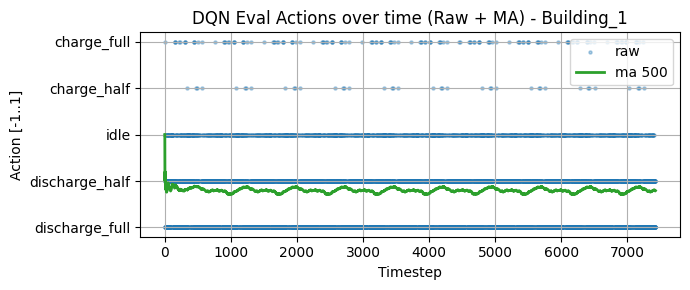

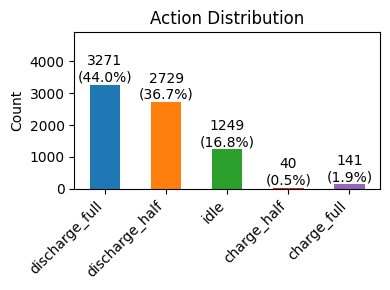

In [96]:
import os, pickle
from matplotlib.ticker import MultipleLocator
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gymnasium as gym
from citylearn.citylearn import CityLearnEnv

# ------------- Helpers -------------
def unwrap_to_citylearn(env):
    cur, seen = env, set()
    while cur is not None and id(cur) not in seen:
        seen.add(id(cur))
        if isinstance(cur, CityLearnEnv):
            return cur
        cur = getattr(cur, "env", getattr(cur, "unwrapped", None))
    raise RuntimeError("CityLearnEnv not found inside wrappers.")

# Load eval_results from eval file
def _ensure_eval_results(path=EVAL_FILE):
    """Load eval_results from file."""
    if os.path.exists(path):
        with open(path, "rb") as f:
            eval_results = pickle.load(f)
            print(f"Eval results loaded from {path}.")
        # Sanity check
        required = {'ep_lengths','actions_disc_list','step_rewards','price_df','episode_len','building_name'}
        missing = required - set(eval_results.keys())
        if missing:
            raise ValueError(f"Loaded eval_results missing keys: {missing}")
        return eval_results
    raise FileNotFoundError(f"{path} not found. Run eval_dqn(...) and save eval_results first.")

def capture_ep_series_dqn(model, env, building_name="Building_1", deterministic=True, max_steps=None, episode_idx=0):
    """Build per-step DataFrame from saved eval_results; no env stepping or model usage."""
    er = _ensure_eval_results()
    needed = ['ep_action_fracs','ep_rewards_list','ep_net_load','ep_non_shiftable_load','ep_price','ep_solar_generation','actions_disc_list','building_name']
    missing = [k for k in needed if k not in er]
    if missing:
        raise ValueError(f"eval_results missing keys: {missing}. Re-run eval_dqn to regenerate with per-step series.")
    n_eps = len(er['ep_rewards_list'])
    if not (0 <= episode_idx < n_eps):
        raise IndexError(f"episode_idx {episode_idx} out of range 0..{n_eps-1}")

    a_id   = np.asarray(er['actions_disc_list'][episode_idx], dtype=int)
    a_frac = np.asarray(er['ep_action_fracs'][episode_idx], dtype=float)
    rew    = np.asarray(er['ep_rewards_list'][episode_idx], dtype=float)
    net    = np.asarray(er['ep_net_load'][episode_idx], dtype=float)
    nsl    = np.asarray(er['ep_non_shiftable_load'][episode_idx], dtype=float)
    price  = np.asarray(er['ep_price'][episode_idx], dtype=float)
    solar  = np.asarray(er['ep_solar_generation'][episode_idx], dtype=float)

    L = len(rew)
    if max_steps is not None:
        L = min(L, int(max_steps))
        a_id, a_frac, rew, net, nsl, price, solar = a_id[:L], a_frac[:L], rew[:L], net[:L], nsl[:L], price[:L], solar[:L]

    df = pd.DataFrame({
        't': np.arange(L, dtype=int),
        'action_id': a_id,
        'action_frac': a_frac,
        'reward': rew,
        'net_load': net,
        'non_shiftable_load': nsl,
        'price': price,
        'solar_generation': solar,
    })
    return df, er.get('building_name', building_name)

er = _ensure_eval_results()
actions_disc = np.concatenate(er['actions_disc_list'], axis=0)
actions_frac = pd.Series(actions_disc).map({0:-1.0, 1:-0.5, 2:0.0, 3:0.5, 4:1.0}).to_numpy()
hour_index = np.arange(len(actions_frac))
building_name = er['building_name']

# Plot 1: Actions over time (raw + MA)
window = 500
act_ma = pd.Series(actions_frac).rolling(window, min_periods=1).mean().to_numpy()
plt.figure(figsize=(7,3))
plt.scatter(hour_index, actions_frac, s=5, alpha=0.35, label='raw')
plt.plot(hour_index, act_ma, color='C2', lw=2, label=f'ma {window}')
plt.title(f'DQN Eval Actions over time (Raw + MA) - {building_name}')
plt.xlabel('Timestep'); plt.ylabel('Action [-1..1]'); plt.grid(True); plt.legend(loc='upper right')
plt.yticks(INT_TO_FRAC.tolist(), ACTION_LABELS)
plt.tight_layout(); plt.show()

# Plot 2: Action Distribution (5-bin)
plt.figure(figsize=(4,3))
counts = pd.Series(actions_disc).value_counts().reindex(range(5)).fillna(0).astype(int)
ax = counts.plot(kind='bar', color=['C0','C1','C2','C3','C4'])
ax.set_xticklabels(ACTION_LABELS, rotation=45, ha='right')
total = counts.sum()
ax.bar_label(ax.containers[0], labels=[f'{int(v)}\n({v/total:.1%})' for v in counts.values])
ax.set_ylim(0, counts.max()*1.5)
plt.ylabel('Count'); plt.title('Action Distribution'); plt.tight_layout(); plt.show()

def add_top_legend(ax_left, ax_right=None, ncol=3, y=1.50, top=0.84, loc='upper center', frameon=False):
    """Place a combined legend above the plot using lines from one or two axes."""
    handles = []
    for ax in (ax_left, ax_right):
        if ax is None:
            continue
        handles.extend(ax.get_lines())
    labels = [h.get_label() for h in handles]
    legend = ax_left.legend(handles, labels, loc=loc, bbox_to_anchor=(0.5, y), ncol=ncol, frameon=frameon)
    if top is not None:
        plt.subplots_adjust(top=top)
    return legend

def plot_first_30_steps_actions_vs_loads_dqn(model, env, building_name="Building_1", deterministic=True):
    df30, bname = capture_ep_series_dqn(model, env, building_name, deterministic=deterministic, max_steps=30)

    t = df30['t'].to_numpy()
    net = df30['net_load'].to_numpy()
    nsl = df30['non_shiftable_load'].to_numpy()
    act = df30['action_frac'].to_numpy()

    fig, ax1 = plt.subplots(figsize=(10.5, 3.6))
    ax1.plot(t, net, color='C4', marker='o', label='Net Load (with storage)')
    ax1.plot(t, nsl, color='C1', ls='--', marker='x', label='Non-shiftable Load (baseline)')
    ax1.set_xlabel('Timestep')
    ax1.set_ylabel('Load')
    ax1.set_xticks(t[::2])
    ax1.set_ylim(-2, 4)  # enforce requested load range
    ax1.yaxis.set_major_locator(MultipleLocator(2))  # enforce ticks every 2 units
    ax1.grid(True, alpha=0.3)

    ax2 = ax1.twinx()
    ax2.step(t, act, where='mid', color='C0', label='Action')
    ax2.set_ylabel('Action')
    ax2.set_ylim(-1.1, 1.1)
    ax2.set_yticks(INT_TO_FRAC.tolist())
    ax2.set_yticklabels(ACTION_LABELS)
    add_top_legend(ax1, ax2)
    plt.title(f'DQN — first 30 steps — {bname} (deterministic={deterministic})')
    plt.tight_layout()
    plt.show()

def plot_ep1_reward_vs_obs_dqn(model, env, building_name="Building_1", deterministic=True, episode_idx=0):
    """Plot using stored eval_results only; no rollout or replay."""
    er = _ensure_eval_results()
    req = ['ep_rewards_list','ep_price','ep_solar_generation','ep_net_load','building_name']
    miss = [k for k in req if k not in er]
    if miss:
        raise ValueError(f"eval_results missing keys: {miss}. Re-run eval_dqn to regenerate with per-step series.")

    n_eps = len(er['ep_rewards_list'])
    if not (0 <= episode_idx < n_eps):
        raise IndexError(f"episode_idx {episode_idx} out of range 0..{n_eps-1}")

    rewards = np.asarray(er['ep_rewards_list'][episode_idx], dtype=float)
    price   = np.asarray(er['ep_price'][episode_idx], dtype=float)
    solar   = np.asarray(er['ep_solar_generation'][episode_idx], dtype=float)
    net     = np.asarray(er['ep_net_load'][episode_idx], dtype=float)
    t = np.arange(len(rewards))

    window_reward = 24
    window_x = 24
    reward_ma = pd.Series(rewards).rolling(window_reward, min_periods=1).mean().to_numpy()
    price_ma  = pd.Series(price).rolling(window_x, min_periods=1).mean().to_numpy()
    solar_ma  = pd.Series(solar).rolling(window_x, min_periods=1).mean().to_numpy()
    net_ma    = pd.Series(net).rolling(window_x, min_periods=1).mean().to_numpy()

    # 4) Reward vs Net Load
    fig, ax1 = plt.subplots(figsize=(12, 3.5))
    ax1.plot(t, reward_ma, color='C3', label=f'Reward MA (w={window_reward})')
    ax1.set_xlabel('Timestep'); ax1.set_ylabel(f'Reward MA ({window_reward})', color='C3')
    ax1.tick_params(axis='y', labelcolor='C3'); ax1.grid(True, axis='x', alpha=0.3)
    ax2 = ax1.twinx()
    ax2.plot(t, net_ma, color='C4', label=f'Net Load MA (w={window_x})')
    ax2.set_ylabel('Net Electricity Consumption', color='C4'); ax2.tick_params(axis='y', labelcolor='C4')
    add_top_legend(ax1, ax2)
    ax1.set_title(f'DQN Episode {episode_idx+1} — Reward vs Net Load — {building_name}')
    plt.tight_layout(); plt.show()

    # 5) Reward vs Electricity Price
    fig, ax1 = plt.subplots(figsize=(12, 3.5))
    ax1.plot(t, reward_ma, color='C3', label=f'Reward MA (w={window_reward})')
    ax1.set_xlabel('Timestep'); ax1.set_ylabel(f'Reward MA ({window_reward})', color='C3')
    ax1.tick_params(axis='y', labelcolor='C3'); ax1.grid(True, axis='x', alpha=0.3)
    ax2 = ax1.twinx()
    ax2.plot(t, price_ma, color='C0', label=f'Price MA (w={window_x})')
    ax2.set_ylabel('Electricity Price', color='C0'); ax2.tick_params(axis='y', labelcolor='C0')
    add_top_legend(ax1, ax2)
    ax1.set_title(f'DQN Episode {episode_idx+1} — Reward vs Electricity Price — {building_name}')
    plt.tight_layout(); plt.show()

    # 6) Reward vs Solar Generation
    fig, ax1 = plt.subplots(figsize=(12, 3.5))
    ax1.plot(t, reward_ma, color='C3', label=f'Reward MA (w={window_reward})')
    ax1.set_xlabel('Timestep'); ax1.set_ylabel(f'Reward MA ({window_reward})', color='C3')
    ax1.tick_params(axis='y', labelcolor='C3'); ax1.grid(True, axis='x', alpha=0.3)
    ax2 = ax1.twinx()
    ax2.plot(t, solar_ma, color='C2', label=f'Solar Gen MA (w={window_x})')
    ax2.set_ylabel('Solar Generation', color='C2'); ax2.tick_params(axis='y', labelcolor='C2')
    add_top_legend(ax1, ax2)
    ax1.set_title(f'DQN Episode {episode_idx+1} — Reward vs Solar Generation — {building_name}')
    plt.tight_layout(); plt.show()


# ----- Plot 3: Actions vs Loads (first 30 steps) -----
#plot_first_30_steps_actions_vs_loads_dqn(model, eval_env, building_name="Building_1", deterministic=False)


# ----- Plot 4,5,6: Actions vs Observations(Net Load, Price, Solar Generation) - first episode -----
#plot_ep1_reward_vs_obs_dqn(model, eval_env, building_name="Building_1", deterministic=False, episode_idx=0)

#### Cumulative Rewards

Episodes available (per env):
    env_id  episode  steps
0        0        1   1463
1        0        2   1463
2        0        3   1463
3        0        4   1463
4        0        5   1463
5        0        6   1463
6        0        7   1463
7        0        8   1463
8        0        9   1463
9        0       10   1463
10       0       11   1463
11       0       12   1463
12       0       13   1463
13       0       14   1463
14       0       15   1463
15       0       16   1463
16       0       17   1463
17       0       18   1463
18       0       19   1463
19       0       20   1463
Plotting env_id=0, episode=1


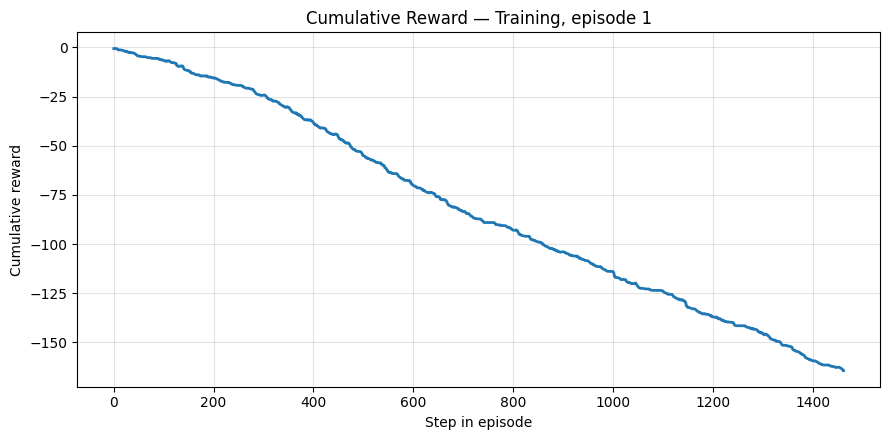

Episode length: 1463 steps | Return: -164.418


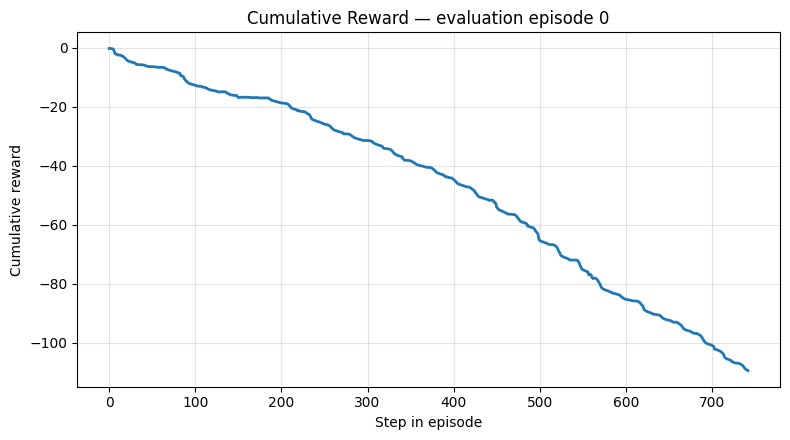

Episode 0 length: 743 steps | Return: -109.362


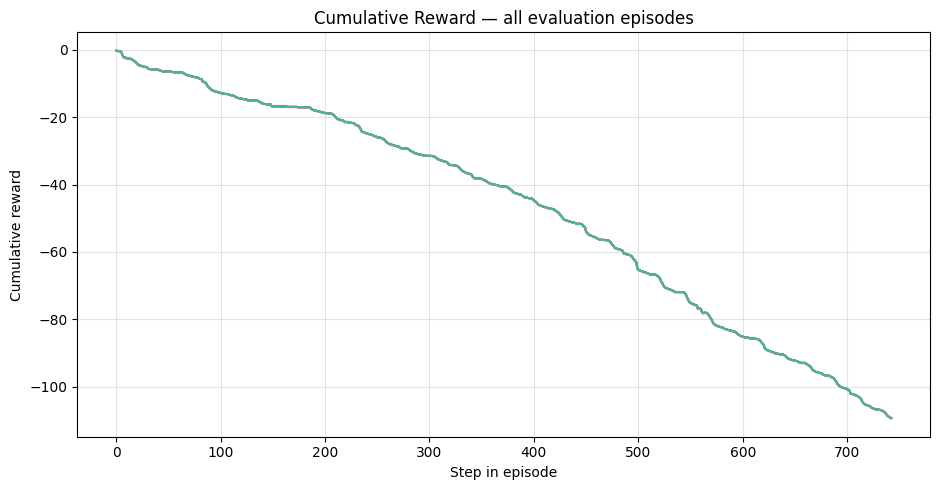

Evaluation episodes summary:
  Ep   0: length=743 steps | Return=-109.362
  Ep   1: length=743 steps | Return=-109.433
  Ep   2: length=743 steps | Return=-109.366
  Ep   3: length=743 steps | Return=-109.381
  Ep   4: length=743 steps | Return=-109.355
  Ep   5: length=743 steps | Return=-109.333
  Ep   6: length=743 steps | Return=-109.439
  Ep   7: length=743 steps | Return=-109.355
  Ep   8: length=743 steps | Return=-109.398
  Ep   9: length=743 steps | Return=-109.363


In [126]:
# === Plot cumulative reward for ONE TRAINING episode from TRAIN_STEPS_FILE ===

ENV_ID = 0           # with DummyVecEnv it's usually 0
EPISODE_IDX = 0      # -1 = last available episode for this ENV_ID; otherwise 0,1,2,...

# Load CSV
csv_path = TRAIN_STEPS_FILE  # e.g., os.path.join(LOG_DIR, "ppo_train_steps_01.csv")
if not os.path.exists(csv_path):
    raise FileNotFoundError(f"TRAIN_STEPS_FILE not found: {csv_path}")

df = pd.read_csv(csv_path)

# Clean up column dtypes
for col in ("reward", "env_id", "episode", "global_step"):
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors="coerce")

# Keep only rows with required fields
need_cols = [c for c in ("env_id", "episode", "reward") if c in df.columns]
df = df.dropna(subset=need_cols)

# Show episode overview per env
episodes_per_env = (
    df.groupby(["env_id", "episode"], as_index=False)["reward"]
      .size()
      .rename(columns={"size": "steps"})
      .sort_values(["env_id", "episode"])
)
print("Episodes available (per env):")
print(episodes_per_env.head(20))

# Select one episode
env_mask = (df["env_id"] == ENV_ID) if "env_id" in df.columns else np.ones(len(df), dtype=bool)
df_env = df.loc[env_mask].copy()
if "episode" not in df_env.columns:
    raise KeyError("CSV has no 'episode' column; cannot segment by episode.")

episodes = sorted(df_env["episode"].dropna().astype(int).unique())
if not episodes:
    raise ValueError(f"No episodes found for env_id={ENV_ID} in {csv_path}")

ep_chosen = episodes[EPISODE_IDX] if EPISODE_IDX != -1 else episodes[-1]
print(f"Plotting env_id={ENV_ID}, episode={ep_chosen}")

# Extract chosen episode in temporal order
order_cols = ["global_step"] if "global_step" in df_env.columns else None
df_ep = df_env.loc[df_env["episode"] == ep_chosen].copy()
if order_cols:
    df_ep = df_ep.sort_values(order_cols)

# Compute cumulative reward
df_ep["reward"] = pd.to_numeric(df_ep["reward"], errors="coerce").fillna(0.0)
df_ep["cum_reward"] = df_ep["reward"].cumsum()
df_ep["t_in_ep"] = np.arange(len(df_ep), dtype=int)

# Plot
plt.figure(figsize=(9, 4.5))
plt.plot(df_ep["t_in_ep"], df_ep["cum_reward"], lw=2)
plt.title(f"Cumulative Reward — Training, episode {ep_chosen}")
plt.xlabel("Step in episode")
plt.ylabel("Cumulative reward")
plt.grid(True, alpha=0.35)
plt.tight_layout()
plt.show()

print(f"Episode length: {len(df_ep)} steps | Return: {df_ep['cum_reward'].iloc[-1]:.3f}")


# === Cumulative reward over timesteps for the FIRST EVALUATION episode (from EVAL_FILE .pkl) ===
assert 'EVAL_FILE' in globals(), "EVAL_FILE is not defined."
if not os.path.exists(EVAL_FILE):
    raise FileNotFoundError(f"Eval file not found: {os.path.abspath(EVAL_FILE)}")

with open(EVAL_FILE, "rb") as f:
    er = pickle.load(f)

def _as_1d_float(x):
    return np.asarray(x, dtype=float).ravel()

def first_episode_step_rewards(data):
    """
    Try common layouts produced by your notebooks:
      - 'ep_rewards_list': list of per-episode step-reward arrays/lists
      - ('step_rewards' + 'ep_lengths'): flat step rewards + per-episode lengths
    Returns: np.ndarray of step rewards for episode 0.
    """
    if isinstance(data, dict):
        # Preferred: list of step-reward sequences per episode
        if "ep_rewards_list" in data and len(data["ep_rewards_list"]) > 0:
            ep0 = data["ep_rewards_list"][0]
            # Some pipelines store floats (already per-episode sum) -> then we can't do cumulative steps
            if isinstance(ep0, (list, tuple, np.ndarray)):
                return _as_1d_float(ep0)

        # Fallback: flat step_rewards segmented by ep_lengths
        if "step_rewards" in data and "ep_lengths" in data:
            step_rewards = _as_1d_float(data["step_rewards"])
            ep_lengths   = np.asarray(data["ep_lengths"], dtype=int).ravel()
            if ep_lengths.size == 0:
                raise ValueError("ep_lengths is empty in eval file.")
            L0 = int(ep_lengths[0])
            if L0 <= 0:
                raise ValueError(f"First episode length is non-positive: {L0}")
            if step_rewards.size < L0:
                raise ValueError(f"Not enough step rewards for first episode: have {step_rewards.size}, need {L0}")
            return step_rewards[:L0]

        # Some variants:
        for k in ("episode_step_rewards", "rewards_per_step", "ep0_step_rewards"):
            if k in data:
                return _as_1d_float(data[k])

    raise ValueError(
        "Could not find per-step rewards for episode 0 in EVAL_FILE. "
        "Expected 'ep_rewards_list' (list of per-step arrays) or ('step_rewards' + 'ep_lengths'). "
        f"Available keys: {list(data.keys()) if isinstance(data, dict) else type(data)}"
    )

# Extract per-step rewards for first eval episode
r0 = first_episode_step_rewards(er)
cum0 = np.cumsum(r0)

# Plot
plt.figure(figsize=(8, 4.5))
plt.plot(np.arange(len(cum0)), cum0, lw=2)
plt.title("Cumulative Reward — evaluation episode 0")
plt.xlabel("Step in episode")
plt.ylabel("Cumulative reward")
plt.grid(True, alpha=0.35)
plt.tight_layout()
plt.show()

print(f"Episode 0 length: {len(r0)} steps | Return: {cum0[-1]:.3f}")

# === Plot cumulative reward for all evaluation episodes ===

def all_episode_step_rewards(data):
    """
    Returns: list of np.ndarray, one per episode, each = per-step rewards.
    Tries the same common layouts as above.
    """
    if isinstance(data, dict):
        # Preferred: list of per-episode step-reward sequences
        if "ep_rewards_list" in data and len(data["ep_rewards_list"]) > 0:
            seqs = []
            for ep in data["ep_rewards_list"]:
                if isinstance(ep, (list, tuple, np.ndarray)):
                    seqs.append(_as_1d_float(ep))
            if seqs:
                return seqs

        # Fallback: flat step_rewards + ep_lengths
        if "step_rewards" in data and "ep_lengths" in data:
            step_rewards = _as_1d_float(data["step_rewards"])
            ep_lengths   = np.asarray(data["ep_lengths"], dtype=int).ravel()
            if ep_lengths.size == 0:
                raise ValueError("ep_lengths is empty in eval file.")
            seqs, idx = [], 0
            for L in ep_lengths:
                if L <= 0:
                    raise ValueError(f"Encountered non-positive episode length: {L}")
                if idx + L > step_rewards.size:
                    raise ValueError(
                        f"Not enough step rewards to slice episode (need idx+L={idx+L}, have {step_rewards.size})"
                    )
                seqs.append(step_rewards[idx:idx+L])
                idx += L
            return seqs

        # Other possible variants (one array per episode or already segmented)
        for k in ("all_episode_step_rewards", "episodes_step_rewards", "episodes"):
            if k in data and isinstance(data[k], (list, tuple)):
                return [ _as_1d_float(x) for x in data[k] ]

    raise ValueError(
        "Could not find per-episode step rewards in EVAL_FILE. "
        "Expected 'ep_rewards_list' (list of per-step arrays) or ('step_rewards' + 'ep_lengths'). "
        f"Available keys: {list(data.keys()) if isinstance(data, dict) else type(data)}"
    )

# Collect all episodes' per-step rewards
episodes_rewards = all_episode_step_rewards(er)

# Overlay plot of cumulative rewards for all episodes
plt.figure(figsize=(9.5, 5))
for i, r in enumerate(episodes_rewards):
    cum = np.cumsum(r)
    plt.plot(np.arange(len(cum)), cum, lw=1.4, alpha=0.7)
plt.title("Cumulative Reward — all evaluation episodes")
plt.xlabel("Step in episode")
plt.ylabel("Cumulative reward")
plt.grid(True, alpha=0.35)
plt.tight_layout()
plt.show()

# Print a compact summary
print("Evaluation episodes summary:")
for i, r in enumerate(episodes_rewards):
    print(f"  Ep {i:>3}: length={len(r)} steps | Return={np.sum(r):.3f}")


#### DecisionTrees

##### DecisionTree

In [ ]:
# ---- Decision Tree (state -> action) ---- ca. 2:30min
# Trains a small DecisionTreeClassifier on (observation -> action) pairs from training logs.
from sklearn.tree import DecisionTreeClassifier, export_text, plot_tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import GridSearchCV, StratifiedKFold

# Load logged steps (x0..xN features, 'action' as label)
def _load_policy_dataset(csv_path=None):
    print(f"Loading training dataset from {csv_path} ...")
    if os.path.exists(csv_path):
        df = pd.read_csv(csv_path)
        print(f"Loaded {len(df)} rows from {os.path.abspath(csv_path)}")
        return df
    if 'train_callback' in globals() and hasattr(train_callback, 'df') and len(train_callback.df):
        print("Using in-memory train_callback.df")
        return train_callback.df.copy()
    raise FileNotFoundError(f"No training dataset found. Ensure {TRAIN_STEPS_FILE} exists or run training first.")

df_steps = _load_policy_dataset(TRAIN_STEPS_FILE)

target_col = "action_id"
drop = {"global_step", "env_id", "episode", "action_label", "action_frac", "reward", target_col}

num_bool = df_steps.select_dtypes(include=[np.number, bool]).columns
feat_cols = sorted([c for c in num_bool if c not in drop])

assert len(feat_cols) > 0, "No features selected – check your dataframe columns!"
print("n_features:", len(feat_cols), "sample:", feat_cols[:10])

feature_names = list(feat_cols)

X = df_steps[feat_cols].to_numpy()
y = df_steps[target_col].astype(int).to_numpy()
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0, stratify=y)

"""
# Train a compact tree (tune depth/leaves for your preference)
# Greedily picks the feature and threshold that best split 
# the training data to reduce class impurity (default: gini)
clf = DecisionTreeClassifier(
    criterion="gini", # 
    max_depth=4,
    min_samples_leaf=50,
    random_state=0,
    class_weight="balanced"
)
clf.fit(X_train, y_train)
"""
# Hyperparameter optimization with GridSearchCV
param_grid = {
    "criterion": ["gini", "entropy", "log_loss"],
    "max_depth": [5],
    "min_samples_leaf": [1, 5, 10, 25, 50],
    "min_samples_split": [2, 5, 10, 20],
    "class_weight": [None, "balanced"],
    "ccp_alpha": [0.0, 0.0005, 0.001, 0.005],
    "splitter": ["best"]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0) # keeps class proportions similar in each fold
grid = GridSearchCV(
    DecisionTreeClassifier(random_state=0),
    param_grid=param_grid,
    scoring="balanced_accuracy",
    cv=cv,
    n_jobs=-1,
    verbose=1
)

grid.fit(X_train, y_train)
print("Best balanced_accuracy:", grid.best_score_)
print("Best params:", grid.best_params_)

clf = grid.best_estimator_

# Evaluate fidelity to the DQN policy
y_pred = clf.predict(X_test)
acc = accuracy_score(y_test, y_pred) # fraction of correctly classified samples
print(f"Surrogate Tree Accuracy: {acc:.3f}")
print("Confusion matrix (rows=true, cols=pred):\n", confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=ACTION_LABELS))

# Global explanations
print("\nTop feature importances:")
imp = clf.feature_importances_
assert len(imp) == len(feature_names), "Mismatch zwischen Importances und Feature-Namen."
imp_idx = np.argsort(imp)[::-1]
for i in imp_idx[:10]:
    if imp[i] <= 0: break
    print(f"- {feature_names[i]}: {imp[i]:.4f}")

#print("\nTree rules (text form):")
#print(export_text(clf, feature_names=feature_names))


# Local explanation for a single timestep
def explain_sample(idx_in_df: int):
    """Print the decision path for a given row index from df_steps."""
    x = df_steps.iloc[idx_in_df][feat_cols].to_numpy().reshape(1, -1)
    true_a = int(df_steps.iloc[idx_in_df][target_col])
    pred_a = int(clf.predict(x)[0])
    proba  = clf.predict_proba(x)[0]
    tree = clf.tree_
    node = 0
    path = []
    while tree.feature[node] != -2:  # -2 => leaf
        f_idx = tree.feature[node]
        thr = tree.threshold[node]
        val = float(x[0, f_idx])
        go_left = val <= thr
        path.append((feature_names[f_idx], val, thr, "left" if go_left else "right"))
        node = tree.children_left[node] if go_left else tree.children_right[node]
    print(f"True action: {true_a} ({ACTION_LABELS[true_a]}), "
          f"Pred: {pred_a} ({ACTION_LABELS[pred_a]}), "
          f"Proba: {dict(zip(ACTION_LABELS, np.round(proba,3)))}")
    print("Decision path:")
    for name, val, thr, side in path:
        print(f" - {name}: {val:.4f} <= {thr:.4f} -> {side}")
    return pred_a

# Example: Random sample from the dataset
_ = explain_sample(idx_in_df=np.random.randint(0, len(df_steps)))

# Visualization with Graphviz (SVG)
try:
    from sklearn.tree import export_graphviz
    import graphviz
    from IPython.display import SVG, display

    dot = export_graphviz(
        clf,
        out_file=None,
        feature_names=feature_names,
        class_names=ACTION_LABELS,
        filled=True,
        rounded=True,
        special_characters=True,
    )
    src = graphviz.Source(dot)
    display(SVG(src.pipe(format='svg')))  # crisp, scalable, no overlaps
except Exception as e:
    print("Graphviz unavailable; falling back to matplotlib (may overlap). Error:", e)
    plt.figure(figsize=(32, 16), dpi=250)
    plot_tree(
        clf,
        feature_names=feature_names,
        class_names=ACTION_LABELS,
        filled=True,
        rounded=True,
        max_depth=4,
        fontsize=14
    )
    plt.tight_layout()
    plt.show()

In [10]:
# ==== Build eval dataset (state -> action) from DQN eval pickle via replay ====
import os, pickle, numpy as np, pandas as pd

EPISODE_IDX = None  # None = alle Episoden; sonst int oder -1 für letzte

with open(EVAL_FILE, "rb") as f:
    ev = pickle.load(f)

# Benötigt im Pickle: diskrete Aktionen pro Episode
assert "actions_disc_list" in ev and len(ev["actions_disc_list"]), "actions_disc_list fehlt im Eval-Pickle."
actions_disc_list = [np.asarray(a, int).ravel() for a in ev["actions_disc_list"]]

# Basis-Env finden (unwrapped), um Beobachtungen zu lesen
def _get_base_env(env):
    cur, seen = eval_env, set()
    while cur is not None and id(cur) not in seen:
        seen.add(id(cur))
        if hasattr(cur, "observations") and hasattr(cur, "buildings"):
            return cur
        cur = getattr(cur, "env", getattr(cur, "unwrapped", None))
    raise RuntimeError("Basis-Env mit 'observations'/'buildings' nicht gefunden.")

base = _get_base_env(eval_env)
bld_names = [b.name for b in base.buildings]
building_name = "Building_1" if "Building_1" in bld_names else bld_names[0]
b_idx = bld_names.index(building_name)

# Observation indices (nur die Features, die du erklären willst)
obs_names = getattr(base, "observation_names", None)
name_to_idx = {n:i for i,n in enumerate(obs_names[b_idx])}

def idx_or_none(*cands):
    for c in cands:
        if c in name_to_idx: return name_to_idx[c]
    return None

i_soc   = idx_or_none("electrical_storage_soc")
i_price = idx_or_none("electricity_pricing")
i_net   = idx_or_none("net_electricity_consumption", "net_electricity_consumption_without_storage")
i_sol   = idx_or_none("solar_generation")

rows = []
episodes_to_use = range(len(actions_disc_list)) if EPISODE_IDX is None else [len(actions_disc_list)-1 if EPISODE_IDX == -1 else int(EPISODE_IDX)]

for epi in episodes_to_use:
    acts = actions_disc_list[epi]
    obs, _ = eval_env.reset()
    done = False
    t = 0
    while not done and t < len(acts) and t < MAX_TIMESTEPS:
        a = int(acts[t])
        obs, r, terminated, truncated, _ = eval_env.step(a)
        done = bool(terminated or truncated)

        raw = base.observations[b_idx]
        row = {
            "episode": epi,
            "t": t,
            "soc":   float(raw[i_soc])   if i_soc   is not None else np.nan,
            "price": float(raw[i_price]) if i_price is not None else np.nan,
            "net_load": float(raw[i_net]) if i_net is not None else np.nan,
            "solar_generation": float(raw[i_sol]) if i_sol is not None else np.nan,
            "action_id": a,
        }
        rows.append(row)
        t += 1

df_eval_states = pd.DataFrame(rows)
print("Eval dataset:", df_eval_states.shape, "cols:", list(df_eval_states.columns))


Eval dataset: (7430, 7) cols: ['episode', 't', 'soc', 'price', 'net_load', 'solar_generation', 'action_id']


##### Huge DT

In [ ]:
# ==== Train Decision Tree surrogate on EVAL states ====
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

ACTION_LABELS = ACTION_LABELS  # aus deinem Notebook (z. B. ["charge_full", ...])

target_col = "action_id"
feat_cols = ["soc", "price", "net_load", "solar_generation"]  # passe an, falls du mehr willst
feat_cols = [c for c in feat_cols if c in df_eval_states.columns]

X = df_eval_states[feat_cols].to_numpy()
y = df_eval_states[target_col].astype(int).to_numpy()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=0, stratify=y
)

param_grid = {
    "criterion": ["gini", "entropy", "log_loss"],
    "max_depth": [4, 5, 6],
    "min_samples_leaf": [5, 10, 25, 50],
    "min_samples_split": [2, 5, 10, 20],
    "class_weight": ["balanced"],  # Klassen oft unausgewogen
    "ccp_alpha": [0.0, 0.0005, 0.001],
    "splitter": ["best"]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
grid = GridSearchCV(
    DecisionTreeClassifier(random_state=0),
    param_grid=param_grid,
    scoring="balanced_accuracy",
    cv=cv, n_jobs=-1, verbose=0
)
grid.fit(X_train, y_train)
clf = grid.best_estimator_

# Evaluation
y_pred = clf.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f"Surrogate Tree Accuracy (eval data): {acc:.3f}")
print("Confusion matrix (rows=true, cols=pred):\n", confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=ACTION_LABELS))

# Top-Features
imp = clf.feature_importances_
for i in np.argsort(imp)[::-1]:
    if imp[i] <= 0: break
    print(f"- {feat_cols[i]}: {imp[i]:.4f}")

# Plot (fallback ohne Graphviz)
plt.figure(figsize=(28, 14), dpi=180)
plot_tree(
    clf,
    feature_names=feat_cols,
    class_names=ACTION_LABELS,
    filled=True,
    rounded=True,
    max_depth=5,
    fontsize=11
)
plt.tight_layout(); plt.show()


##### View most important split nodes

In [12]:
# ==== Show top split nodes (most important rules) ====
import numpy as np

def print_top_splits(clf, feature_names, class_names, topk=10):
    t = clf.tree_
    n_nodes = t.node_count
    left, right = t.children_left, t.children_right
    feat_idx, thr = t.feature, t.threshold
    imp, w = t.impurity, t.weighted_n_node_samples

    # gewichtete Impurity-Reduktion je Knoten (0..root normiert)
    root_weight = w[0]
    scores = []
    for i in range(n_nodes):
        if left[i] == -1:  # leaf
            continue
        gain = (imp[i]*w[i] - imp[left[i]]*w[left[i]] - imp[right[i]]*w[right[i]]) / root_weight
        scores.append((gain, i))

    scores.sort(reverse=True, key=lambda x: x[0])
    print(f"\nTop {min(topk,len(scores))} split nodes by weighted impurity reduction:")
    for rank, (gain, i) in enumerate(scores[:topk], 1):
        f = feature_names[feat_idx[i]]
        thr_i = thr[i]
        n = int(w[i])
        dist = t.value[i][0]  # Klassenhäufigkeiten
        pred = class_names[np.argmax(dist)]
        print(f"{rank:2d}. if {f} <= {thr_i:.4f}  (samples={n}, gain={gain:.6f})  -> node#{i}, pred≈{pred}, class-dist={np.round(dist,1)}")

print_top_splits(clf, feat_cols, ACTION_LABELS, topk=10)


Top 10 split nodes by weighted impurity reduction:
 1. if price <= 0.0475  (samples=5572, gain=0.100053)  -> node#0, pred≈discharge_full, class-dist=[0.2 0.2 0.2 0.2 0.2]
 2. if solar_generation <= 0.2558  (samples=1999, gain=0.053672)  -> node#1, pred≈charge_full, class-dist=[0.1 0.1 0.  0.3 0.5]
 3. if net_load <= 2.2167  (samples=3572, gain=0.036292)  -> node#50, pred≈idle, class-dist=[0.3 0.3 0.3 0.1 0. ]
 4. if price <= 0.1091  (samples=925, gain=0.022629)  -> node#82, pred≈charge_half, class-dist=[0.2 0.2 0.1 0.5 0. ]
 5. if price <= 0.0670  (samples=1051, gain=0.021660)  -> node#78, pred≈charge_half, class-dist=[0.2 0.2 0.1 0.4 0.1]
 6. if net_load <= 1.8809  (samples=392, gain=0.017906)  -> node#35, pred≈charge_full, class-dist=[0.2 0.2 0.2 0.  0.4]
 7. if price <= 0.0927  (samples=476, gain=0.015823)  -> node#84, pred≈charge_half, class-dist=[0.1 0.2 0.2 0.5 0. ]
 8. if price <= 0.0001  (samples=640, gain=0.015495)  -> node#3, pred≈charge_half, class-dist=[0.  0.  0.  0.5 0.5

##### test

##### DecisionTree from Eval file deterministic & stochastic

In [32]:
# ================== Compact Decision-Tree plotting (robust) ===================
import os, shutil
import numpy as np
import matplotlib.pyplot as plt
from graphviz import Digraph
from IPython.display import SVG, display
from sklearn.tree import DecisionTreeClassifier, plot_tree

# ---------- small helpers ----------
def ensure_dir(d: str) -> str:
    os.makedirs(d, exist_ok=True)
    return d

def graphviz_available() -> bool:
    try:
        import graphviz  # noqa: F401
        return shutil.which("dot") is not None
    except Exception:
        return False

# optional: kurze Feature-Namen
SHORT_MAP = {
    "electricity_pricing": "price",
    "net_electricity_consumption_without_storage": "net_load",
    "net_electricity_consumption": "net_load",
    "solar_generation": "solar",
    "electrical_storage_soc": "soc",
}
def shorten_feats(feats):
    return [SHORT_MAP.get(f, f) for f in feats]

# Farben pro Feature-Gruppe
FEATURE_COLORS = {
    "price":   "#fee8c8",
    "net_load":"#c7e9c0",
    "solar":   "#c6dbef",
    "soc":     "#fdd0a2",
    "default": "#eeeeee",
}
def _feat_color(name: str) -> str:
    n = name.lower()
    if "price" in n: return FEATURE_COLORS["price"]
    if "net" in n and "load" in n: return FEATURE_COLORS["net_load"]
    if "solar" in n: return FEATURE_COLORS["solar"]
    if "soc"   in n: return FEATURE_COLORS["soc"]
    return FEATURE_COLORS["default"]

# ---- pruning: safe ccp_alpha sequence and <= max_leaves ----
def prune_to_max_leaves(clf_params: dict, X, y, max_leaves=8, random_state=0):
    """Cost-complexity pruning; robust gegen winzige negative Alphas."""
    base = DecisionTreeClassifier(random_state=random_state, **clf_params)
    path = base.cost_complexity_pruning_path(X, y)
    # Clip tiny negatives, unique & aufsteigend; immer 0.0 mitnehmen
    alphas = np.r_[0.0, np.unique(np.clip(path.ccp_alphas, 0.0, None))]

    chosen = None
    last_cand = None
    for a in alphas:
        cand = DecisionTreeClassifier(
            random_state=random_state, ccp_alpha=float(a), **clf_params
        ).fit(X, y)
        last_cand = cand
        leaves = (cand.tree_.children_left == -1).sum()
        if leaves <= max_leaves:
            chosen = cand
            break
    return chosen if chosen is not None else last_cand

# ---- weighted Δimp (richtige Größen aus dem Baum verwenden) ----
def _delta_impurity_weighted(T, node: int) -> float:
    """Weighted impurity reduction for a split node."""
    L, R = T.children_left[node], T.children_right[node]
    if L == -1 or R == -1:
        return 0.0
    Wp = T.weighted_n_node_samples[node]
    Wl = T.weighted_n_node_samples[L]
    Wr = T.weighted_n_node_samples[R]
    gp = T.impurity[node]
    gl = T.impurity[L]
    gr = T.impurity[R]
    # kleine negative Reste durch Rundung clippen
    return max(Wp*gp - Wl*gl - Wr*gr, 0.0)

# ---- Graphviz Renderer: kompakte Labels + „…“ am Trunkationspunkt ----
def render_compact_tree_graphviz(
    clf, feature_names, class_names,
    max_depth=3, ranksep="0.5", nodesep="0.3",
    topk_actions=3
) -> Digraph:
    """Kompakter Graphviz-Plot:
       - Interne Knoten: 'feature ≤ threshold', 'Δimp', '→ Mehrheitsaktion'
       - Blätter: 'class: <aktion>'
       - Trunkation (depth >= max_depth): statt IDs -> 'Top actions'-Kästen (ohne summary)
    """
    T = clf.tree_

    dot = Digraph(
        "tree",
        graph_attr={"ranksep": str(ranksep), "nodesep": str(nodesep), "splines":"true"},
        node_attr={"shape":"box","style":"rounded,filled","fontname":"Helvetica","fontsize":"10"},
        edge_attr={"fontname":"Helvetica","fontsize":"9"},
    )




    FEATURE_COLORS = {
        "price":   "#fee8c8",
        "net_load":"#c7e9c0",
        "solar":   "#c6dbef",
        "soc":     "#fdd0a2",
        "default": "#eeeeee",
    }
    def _feat_color(name:str)->str:
        n = name.lower()
        if "price" in n: return FEATURE_COLORS["price"]
        if "net" in n and "load" in n: return FEATURE_COLORS["net_load"]
        if "solar" in n: return FEATURE_COLORS["solar"]
        if "soc"   in n: return FEATURE_COLORS["soc"]
        return FEATURE_COLORS["default"]

    def _delta_imp(node:int) -> float:
        """Gewichtete Δ-Impurity (nutzt weighted_n_node_samples; kleine Negativwerte -> 0)."""
        L, R = T.children_left[node], T.children_right[node]
        if L == -1 or R == -1:
            return 0.0
        Wp, Wl, Wr = (T.weighted_n_node_samples[node],
                      T.weighted_n_node_samples[L],
                      T.weighted_n_node_samples[R])
        gp, gl, gr = T.impurity[node], T.impurity[L], T.impurity[R]
        d = Wp*gp - Wl*gl - Wr*gr
        return float(max(d, 0.0))

    def _majority(node:int) -> str:
        v = T.value[node][0].astype(float)
        s = v.sum()
        if s > 0: v /= s
        return class_names[int(np.argmax(v))]

    def _top_actions_label(node:int, k:int) -> str:
        """Nur Top-k Aktionen mit Prozenten, keine summary/Gini/Nw."""
        v = T.value[node][0].astype(float)
        s = v.sum()
        if s <= 0:
            return "top actions\n(n/a)"
        p = v / s
        idx = np.argsort(-p)[:min(k, len(class_names))]
        lines = [f"{class_names[i]} {int(round(100*p[i]))}%" for i in idx if p[i] > 0]
        return "\n".join(lines)

    def _node_label(n:int) -> str:
        if T.children_left[n] == -1:
            return f"class: {_majority(n)}"
        feat = feature_names[T.feature[n]]
        thr  = T.threshold[n]
        return f"{feat} ≤ {thr:.3f}\nΔimp: {_delta_imp(n):.1f}\n→ {_majority(n)}"

    def add(n:int, depth:int=0):
        is_leaf = (T.children_left[n] == -1)
        fill = "#f5f5f5" if is_leaf else _feat_color(feature_names[T.feature[n]])
        dot.node(str(n), _node_label(n), fillcolor=fill)

        if is_leaf:
            return

        if depth >= max_depth:
            # Statt Unterbaum: je Kind ein 'Top actions'-Kasten
            L, R = T.children_left[n], T.children_right[n]
            for child, lab, suf in ((L, "True", "L"), (R, "False", "R")):
                pid = f"{n}_{suf}_top"
                dot.node(pid, _top_actions_label(child, topk_actions),
                         shape="box", style="rounded,filled", fillcolor="#dddddd")
                dot.edge(str(n), pid, label=lab)
            return

        L, R = T.children_left[n], T.children_right[n]
        add(L, depth+1); add(R, depth+1)
        dot.edge(str(n), str(L), label="True")
        dot.edge(str(n), str(R), label="False")

    add(0, 0)
    return dot

# ---- Hauptfunktion: prunen, rendern, speichern; Matplotlib-Fallback ----
def plot_tree_robust(
    clf, X_train, y_train, feat_cols, class_names,
    out_dir="figures", base="tree_compact",
    max_leaves=8, max_depth=3,
    clf_params=None,
):
    """
    Zeichnet einen kompakten, farbcodierten Entscheidungsbaum (SVG/PNG).
    - clf: vorhandener DecisionTreeClassifier oder None (dann wird einer via Pruning trainiert)
    - X_train, y_train: Trainingsdaten für den Surrogatbaum
    - feat_cols: Feature-Namen (gleiche Reihenfolge wie Spalten in X_train)
    - class_names: Klassenbezeichnungen (z.B. deine Aktionslabels)
    """
    ensure_dir(out_dir)
    feat_short = shorten_feats(feat_cols)

    if clf is None:
        params = dict(
            criterion="gini",
            max_depth=None,
            min_samples_leaf=20,
            min_samples_split=40,
            class_weight="balanced",
            splitter="best",
        )
        if clf_params:
            params.update(clf_params)
        clf = prune_to_max_leaves(params, X_train, y_train, max_leaves=max_leaves, random_state=0)

    if graphviz_available():
        dot = render_compact_tree_graphviz(clf, feat_short, class_names, max_depth=max_depth)
        svg_out = os.path.join(out_dir, base)
        dot.render(svg_out, format="svg", cleanup=True)
        dot.render(svg_out, format="png", cleanup=True)
        print(f"Saved: {svg_out}.svg and {svg_out}.png")
        # Inline-Anzeige (Notebook)
        try:
            display(SVG(dot.pipe(format="svg")))
        except Exception:
            pass
    else:
        print("[Info] Graphviz 'dot' not found. Falling back to sklearn.plot_tree.")
        plt.figure(figsize=(12, 6), dpi=160)
        plot_tree(
            clf,
            feature_names=feat_short,
            class_names=class_names,
            filled=True, rounded=True,
            impurity=False, proportion=False,
            max_depth=max_depth, fontsize=10,
            label="none",  # versteckt numerische Node-IDs
        )
        plt.tight_layout()
        png_path = os.path.join(out_dir, base + "_matplotlib.png")
        plt.savefig(png_path, dpi=200, bbox_inches="tight")
        plt.show()
        print(f"Saved: {png_path}")


Saved: figures/tree_dqn_deterministic.svg and figures/tree_dqn_deterministic.png


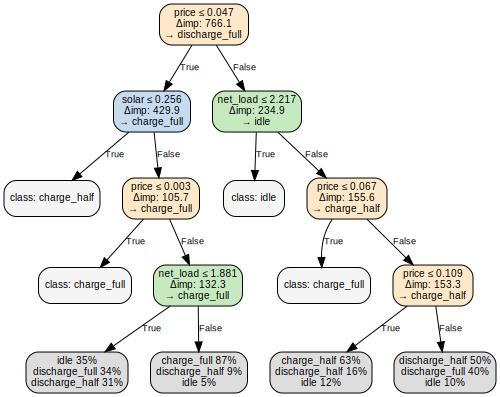

Saved: figures/tree_dqn_stochastic.svg and figures/tree_dqn_stochastic.png


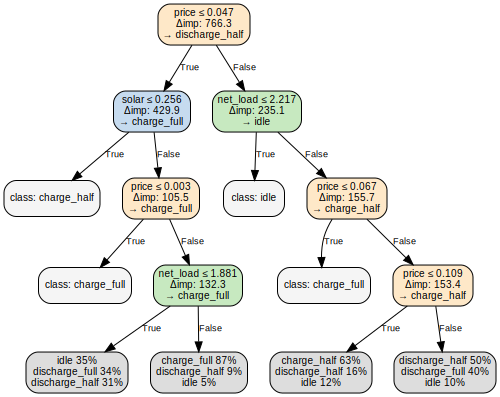

In [33]:
# --- Build X, y from an eval results dict ------------------------------------
import pickle
import numpy as np

ACTION_LABELS = ['discharge_full','discharge_half','idle','charge_half','charge_full']
NAME_TO_FRAC = {'discharge_full':-1.0,'discharge_half':-0.5,'idle':0.0,'charge_half':0.5,'charge_full':1.0}
INT_TO_FRAC = np.array([-1.0, -0.5, 0.0, 0.5, 1.0], dtype=np.float32)  # if you have 5 discrete actions

def prune_to_max_leaves(clf_params: dict, X, y, max_leaves=8, random_state=0):
    """Cost-complexity pruning with safe non-negative alphas."""
    base = DecisionTreeClassifier(random_state=random_state, **clf_params)
    path = base.cost_complexity_pruning_path(X, y)
    # Clip tiny negative alphas to 0 and deduplicate (keep ascending order)
    alphas = np.r_[0.0, np.unique(np.clip(path.ccp_alphas, 0.0, None))]

    best = None
    for a in alphas:
        a = float(a)  # ensure plain Python float
        cand = DecisionTreeClassifier(random_state=random_state,
                                      ccp_alpha=a, **clf_params).fit(X, y)
        leaves = (cand.tree_.children_left == -1).sum()
        if leaves <= max_leaves:
            best = cand
            break

    # Fallback: if no alpha produced <= max_leaves, return the last candidate
    if best is None:
        best = DecisionTreeClassifier(random_state=random_state,
                                      ccp_alpha=float(alphas[-1]), **clf_params).fit(X, y)
    return best

def load_eval(path):
    with open(path, "rb") as f:
        return pickle.load(f)

def as_1d_list(res, key):
    """Flatten list-of-episodes -> one long 1D array."""
    if key not in res:
        return None
    out = []
    for arr in res[key]:
        a = np.asarray(arr).ravel()
        if a.size:
            out.append(a)
    return np.concatenate(out) if out else None

def features_and_labels_from_eval(res, use_soc=True):
    # features (order must match your 'feat_cols')
    price = as_1d_list(res, "ep_price")
    net   = as_1d_list(res, "ep_net_load")
    solar = as_1d_list(res, "ep_solar_generation")
    soc   = as_1d_list(res, "ep_soc") if use_soc and ("ep_soc" in res) else None

    feats = [price, net, solar] if soc is None else [price, net, solar, soc]
    if any(v is None for v in feats):
        raise ValueError("Missing per-episode series in eval dict (need ep_price, ep_net_load, ep_solar_generation, optional ep_soc).")
    X = np.vstack(feats).T  # shape (N, d)

    # labels: prefer discrete IDs if present; else map continuous actions to nearest bin
    if "actions_disc_list" in res:
        y = as_1d_list(res, "actions_disc_list").astype(int)
    elif "ep_action_fracs" in res:
        a = as_1d_list(res, "ep_action_fracs").astype(float)
        # map to nearest of [-1,-0.5,0,0.5,1] → indices 0..4
        bins = np.array([-1.0, -0.5, 0.0, 0.5, 1.0])
        y = np.argmin(np.abs(a[:,None] - bins[None,:]), axis=1).astype(int)
    else:
        raise ValueError("No actions found in eval dict (need actions_disc_list or ep_action_fracs).")

    return X, y

# Example: build two trees, one per eval file
res_det = load_eval(EVAL_FILE_DETERMINISTIC)
res_sto = load_eval(EVAL_FILE_STOCHASTIC)

# Make sure feat_cols matches the X columns you produce here:
feat_cols_det = ["electricity_pricing","net_electricity_consumption_without_storage","solar_generation","electrical_storage_soc"]
feat_cols_sto = feat_cols_det

X_det, y_det = features_and_labels_from_eval(res_det, use_soc=True)
X_sto, y_sto = features_and_labels_from_eval(res_sto, use_soc=True)

# Fit pruned trees and render (reusing your robust plotting function)
plot_tree_robust(
    clf=None, X_train=X_det, y_train=y_det,
    feat_cols=feat_cols_det, class_names=ACTION_LABELS,
    out_dir="figures", base="tree_dqn_deterministic",
    max_leaves=8, max_depth=3
)

plot_tree_robust(
    clf=None, X_train=X_sto, y_train=y_sto,
    feat_cols=feat_cols_sto, class_names=ACTION_LABELS,
    out_dir="figures", base="tree_dqn_stochastic",
    max_leaves=8, max_depth=3
)
